In [2]:
import numpy as np
import pandas as pd
import geopy as geo
from shapely.geometry import shape, Point
import json

# I] Cleaning the data

In [3]:
dataset_path = 'resources/food-inspections.csv'
dataset = pd.read_csv(dataset_path, sep=',').drop(['Zip Codes', 'Community Areas', 'Census Tracts', 'Wards', 'Historical Wards 2003-2015'], axis=1)

## 1) Cleaning the city and keeping only Chicago's shops

### 1. Separating the data

In [4]:
with_location = dataset[dataset['Location'].astype('str') != "nan"]
missing_location = dataset[dataset['Location'].astype('str') == "nan"]
print('Shops with coordinates: {}'.format(with_location.shape[0]))
print('Shops without coordinates: {}'.format(missing_location.shape[0]))

Shops with coordinates: 194221
Shops without coordinates: 683


### 2. Cleaning with coordinates

In [5]:
# Only keeping shops with address in Chicago
# Warning, takes about 10mins!

with open('resources/chicago-city.geojson') as f0:
    chicago_border = json.load(f0)

chicago_shape = shape(chicago_border['features'][0]['geometry'])

def is_in_chicago(lng_lat):
    point = Point(lng_lat[0], lng_lat[1])    
    return chicago_shape.contains(point)

with_chicago_location = with_location[with_location[['Longitude', 'Latitude']].apply(is_in_chicago, axis=1)]
print('Shops with coordinates in Chicago: {}'.format(with_chicago_location.shape[0]))

Shops with coordinates in Chicago: 191329


There is no missing address, city or state in missing_location_dataset.  
Thus we can try to find their coordinates with the help of [GeoPy](https://geopy.readthedocs.io/en/latest/#). 


### 3. Cleaning with address

In [6]:
# First we will keep only the shops in IL
illinois_shops = missing_location[missing_location.State == 'IL']
print("Shops with missing location in IL: {}".format(illinois_shops.shape[0]))

illinois_shops_with_city = illinois_shops[illinois_shops['City'].astype('str') != "nan"]
print("Shops with missing location in IL with a city name: {}".format(illinois_shops_with_city.shape[0]))

# Then we rename the cities misspelling Chicago and add chicago to others
def rename_if_chicago(city_name):
    n_city = city_name.lower()
    if 'cago' in n_city:
        return 'chicago'
    return 'chicago ' + n_city

illinois_shops_with_city['City'] = illinois_shops_with_city['City'].map(rename_if_chicago)

Shops with missing location in IL: 680
Shops with missing location in IL with a city name: 677


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [7]:
# Getting the coordinates from some maps provider (here Bing)
geo.geocoders.options.default_user_agent = 'my_app/1'
geo.geocoders.options.default_timeout = 20
geolocator = geo.geocoders.Bing(api_key='AqZbhCYki5TkYlGbyLBfTJR5wfwpLJ22S-D3p_DRJxfDIyYY4wTRsq6gxPCdAXSV')

def get_location(full_address):
    address = ' '.join(full_address)
    loc = geolocator.geocode(address)
    return loc.longitude, loc.latitude

new_locations = illinois_shops_with_city[['Address','City','State']].apply(get_location, axis=1)

In [53]:
pos = pd.DataFrame(new_locations.copy(), columns=['position'])
pos.position = pos.position.astype(str)
pos.position = pos["position"].str.strip('()')
coords = pos["position"].str.split(", ", n = 1, expand = True)

illinois_shops_with_city['Longitude'] = coords[0].astype(float)
illinois_shops_with_city['Latitude'] = coords[1].astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [55]:
# We only keep those in Chicago borders
chicago_shops_without_location = illinois_shops_with_city[illinois_shops_with_city[['Longitude', 'Latitude']].apply(is_in_chicago, axis=1)]
print("Shops with missing location in Chicago: {}".format(chicago_shops_without_location.shape[0]))

Shops with missing location in Chicago: 498


In [59]:
# Merging the result
chicago_shops = pd.concat([with_chicago_location, chicago_shops_without_location])
print("We have {} shops within Chicago's borders!".format(chicago_shops.shape[0]))

We have 191827 shops within Chicago's borders!


### Checkpoint, saving the data

In [67]:
# Dropping useless columns and saving the data
chicago_shops.drop(columns=['Location','State','City']).to_parquet('resources/food-inspections-part1.parquet')

## 2) Assign matching types to columns

In [119]:
dataset = pd.read_parquet('resources/food-inspections-part1.parquet')
dataset['Inspection Date'] = pd.to_datetime(dataset['Inspection Date'])
dataset['Zip'] = dataset['Zip'].fillna(0).astype(int)
dataset['License #'] = dataset['License #'].fillna(0).astype(int)
print("New type:\n")
dataset.dtypes

New type:



Inspection ID               int64
DBA Name                   object
AKA Name                   object
License #                   int64
Facility Type              object
Risk                       object
Address                    object
Zip                         int64
Inspection Date    datetime64[ns]
Inspection Type            object
Results                    object
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

### Checkpoint, saving the data

In [122]:
# Dropping useless columns and saving the data
dataset.to_parquet('resources/food-inspections-part2.parquet')

In [123]:
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type           Risk                  Address    Zip  \
0    Restaurant  Risk 1 (High)  4634-4636 N KEDZIE AVE   60625   
1    Restaurant  Risk 1 (High)     2114 W LAWRENCE AVE   60625   
2    Restaurant  Risk 1 (High)     3028 W ARMITAGE AVE   60647   
3    Restaurant  Risk 1 (High)          2020 W CHICAGO   60622   
4    Restaurant  Risk 1 (High)     2545 W DIVERSEY AVE   60647   

  Inspection Date          Inspection Type             Results  \
0      2019-10-25  Complaint Re-Inspection                Pass   
1      2019-10-25    License Re-Inspection                Fail   
2      2019-10-24                  Canvass                Fail   
3      2019-10-24    License Re-Inspection  Pass w/ Conditions   
4      2019-10-24        Recent Inspection  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  
0                                               None  41.965719 -87.708538  
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292  
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728  
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938  
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169

## 3) Rewriting the Risk column

In [39]:
# We load the last checkpoint
dataset = pd.read_parquet('resources/food-inspections-part2.parquet')

In [40]:
# First, let's see what are the possible risks
np.array(dataset.Risk.unique())

array(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)', 'All', None],
      dtype=object)

In [41]:
dictionnary = {'Risk 1 (High)': 'High', 'Risk 2 (Medium)': 'Medium', 'Risk 3 (Low)': 'Low', 'All': 'All', None: None}
dataset.Risk = dataset.Risk.map(dictionnary)

In [55]:
# Now it's a bit clearer and easier to search
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type             Results  \
0       Complaint                Pass   
1         License                Fail   
2         Canvass                Fail   
3         License  Pass w/ Conditions   
4          Others  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                               None  41.965719 -87.708538   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292   
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938   
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169   

   Re-inspection  
0           True  
1           True  
2          False  
3           True  
4          False

### Checkpoint, saving the data

In [44]:
dataset.to_parquet('resources/food-inspections-part3.parquet')

## 4) Exploding the inspection

In [204]:
# We load the last checkpoint
dataset = pd.read_parquet('resources/food-inspections-part3.parquet')

In [205]:
# There is a lot to unfold here.
# First we will put all text to lowercase
dataset['Inspection Type'] = dataset['Inspection Type'].str.lower()

In [206]:
# Then we will filter all the inpection labels to find which type they correspond to

def substring_in_word(word, substrings):
    for s in substrings:
        if s.lower() in word.lower():
            return True
    return False

def find_inspection_type(inspection):
    if inspection == None:
        return 'Unknown', False
    
    lc_name = inspection.lower()
    i_type = 'Others'
    i_repeat = False
    
    if substring_in_word(lc_name, ['changed', 'closed', 'out of', 'cancelled', 'suspended', 'not ready', 'not located', 'wrong', 'non-inspection']):
        i_type = 'Cancelled'
    elif substring_in_word(lc_name, ['task', 'tavern', 'liquor']):
        i_type = 'Task-force'
    elif substring_in_word(lc_name, ['consultation']):
        i_type = 'Consultation'
    elif substring_in_word(lc_name, ['license']):
        i_type = 'License'
    elif substring_in_word(lc_name, ['complain']):
        i_type = 'Complaint'
    elif substring_in_word(lc_name, ['food poisoning', 'got sick']):
        i_type = 'Suspect food poisoning'
    elif substring_in_word(lc_name, ['canvas']):
        i_type = 'Canvass'
    
    if substring_in_word(lc_name, ['reinspection', 're-inspection', 're inspection']):
        i_repeat = True
    
    return i_type, i_repeat

In [207]:
dataset['Inspection Type'] = dataset['Inspection Type'].map(find_inspection_type)
dataset['Inspection Type'].value_counts()

(Canvass, False)                   100957
(License, False)                    25428
(Complaint, False)                  24901
(Canvass, True)                     20133
(License, True)                      8881
(Complaint, True)                    7499
(Others, False)                      1073
(Task-force, False)                   921
(Suspect food poisoning, False)       828
(Consultation, False)                 681
(Cancelled, False)                    334
(Suspect food poisoning, True)        185
(Others, True)                          5
(Unknown, False)                        1
Name: Inspection Type, dtype: int64

In [208]:
# Re-assign the inspection type values and add a re-inspection column
dataset['Re-inspection'] = dataset['Inspection Type'].map(lambda x: x[1])
dataset['Inspection Type'] = dataset['Inspection Type'].map(lambda x: x[0])

In [209]:
# Now the inspection data is easier to use!
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type             Results  \
0       Complaint                Pass   
1         License                Fail   
2         Canvass                Fail   
3         License  Pass w/ Conditions   
4          Others  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                               None  41.965719 -87.708538   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292   
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938   
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169   

   Re-inspection  
0           True  
1           True  
2          False  
3           True  
4          False

### Checkpoint, saving the data

In [210]:
dataset.to_parquet('resources/food-inspections-part4.parquet')

## 5) Facility types, here we are!

In [221]:
# We load the last checkpoint
dataset = pd.read_parquet('resources/food-inspections-part4.parquet')
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type             Results  \
0       Complaint                Pass   
1         License                Fail   
2         Canvass                Fail   
3         License  Pass w/ Conditions   
4          Others  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                               None  41.965719 -87.708538   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292   
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938   
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169   

   Re-inspection  
0           True  
1           True  
2          False  
3           True  
4          False

In [222]:
print("Number of facility types: {}".format(dataset['Facility Type'].str.lower().unique().size))

Number of facility types: 432


They are more than 400 hundreds facility types which will seriously complicate our data analysis.  
Thus, we will only label facility types explicitely described in the [Chicago Food Inspection description](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF):  
* bakery  
* banquet hall  
* candy store  
* caterer  
* coffee shop  
* day care center (< 2 yo)  
* day care center (2-6 yo)  
* day care center (0-6 yo)  
* gas station  
* Golden Dinner  
* grocery store  
* hospital 
* long term care center(nursing home)  
* liquor store  
* mobile food dispenser  
* restaurant  
* paleteria  
* school  
* shelter  
* tavern  
* social club  
* wholesaler  
* Wrigley Field Rooftop

In [223]:
def filter_none(x):
    return x != None and '/' in x

print("Shops with 2 types: {}".format(dataset[dataset['Facility Type'].apply(filter_none)].size))
print("Shops with 1 type: {}".format(dataset.size))

Shops with 2 types: 9360
Shops with 1 type: 2877405


Some shops are hybrids types where the types are separated by a slash.  
As they represent a very small part of a dataset, we will only consider the first category they fit, or the second if the first is uncategorizable.

In [224]:
def find_facility_type(facility):
    if facility == None:
        return 'Unknown'
    
    split = facility.lower().split('/')
    lc_name = split[0]
    f_types = []
    
    if 'hospital' in lc_name:
        return 'Hospital'
        
    elif substring_in_word(lc_name, ['banquet', 'hall']):
        return 'Banquet hall'
        
    elif substring_in_word(lc_name, ['ice cream', 'paleteria', 'gelato', 'candy']):
        return 'Sweetshop'
        
    elif substring_in_word(lc_name, ['cater', 'butcher', 'deli']):
        return 'Caterer'
        
    elif substring_in_word(lc_name, ['cafe', 'coffee', 'kiosk']):
        return 'Coffee shop'
                           
    elif substring_in_word(lc_name, ['dispenser', 'mobile', 'truck', 'cart']):
        return 'Mobile food dispenser'
                                                     
    elif 'gas' in lc_name:
        return 'Gas station'
                           
    elif 'golden' in lc_name:
        return 'Golden Dinner'
        
    elif substring_in_word(lc_name, ['liquor', 'liqour', 'wine']):
        return 'Liquor store'
        
    elif substring_in_word(lc_name, ['tavern', 'bar', 'brewery', 'brewpub']):
        return 'Tavern'
                           
    elif substring_in_word(lc_name, ['grocery', 'market', 'convenience', 'store']):
        return 'Grocery store'
                           
    elif substring_in_word(lc_name, ['pantry', 'bakery']):
        return 'Bakery'
        
    elif substring_in_word(lc_name, ['wholesale', 'slaughter', 'live', 'warehouse']):
        return 'Wholesaler'
        
    elif substring_in_word(lc_name, ['school', 'shcool', 'college']):
        return 'School'
        
    elif substring_in_word(lc_name, ['services facility', 'service facility']):
        return 'Childrens services facility'
        
    elif substring_in_word(lc_name, ['roof']):
        return 'Rooftop'
        
    elif substring_in_word(lc_name, ['shared']):
        return 'Shared kitchen'
        
    elif substring_in_word(lc_name, ['nursing', 'care center', 'senior', 'long term care', 'assisted', 'supportive']):
        return 'Long term care center'

    elif 'restaurant' in lc_name:
        return 'Restaurant'
    
    elif 'shelter' in lc_name:
        return 'Shelter'
        
    elif substring_in_word(lc_name, ['(Under 2 Years)', 'Daycare (2 Years)']):
        return 'Daycare (0-2 yo)'

    elif substring_in_word(lc_name, ['combo', 'Above and Under 2 Years', '6 WKS-5YRS']):
        return 'Daycare (0-6 yo)'
            
    elif substring_in_word(lc_name, ['2-6', '(2 - 6 Years)', 'DAY CARE ABOVE 2 YEARS']):
        return 'Daycare (2-6 yo)'
    
    elif substring_in_word(lc_name, ['daycare', 'day care']):
        return 'Daycare (others)'
    
    elif len(split) > 1:
        return find_facility_type(split[1])
    
    else:
        return 'Others'
    
    return f_type

In [225]:
dataset['Facility Type'] = dataset['Facility Type'].map(find_facility_type)
print('We have now {} distinct categories!'.format(dataset['Facility Type'].unique().size))

We have now 26 distinct categories!


### Checkpoint, saving the data

In [226]:
dataset.to_parquet('resources/food-inspections-part5.parquet')

In [227]:
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type             Results  \
0       Complaint                Pass   
1         License                Fail   
2         Canvass                Fail   
3         License  Pass w/ Conditions   
4          Others  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                               None  41.965719 -87.708538   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292   
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938   
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169   

   Re-inspection  
0           True  
1           True  
2          False  
3           True  
4          False

## 6) Adding the neighborhoods and community areas

In [3]:
# We load the last checkpoint
dataset = pd.read_parquet('resources/food-inspections-part5.parquet')
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type             Results  \
0       Complaint                Pass   
1         License                Fail   
2         Canvass                Fail   
3         License  Pass w/ Conditions   
4          Others  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                               None  41.965719 -87.708538   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292   
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938   
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169   

   Re-inspection  
0           True  
1           True  
2          False  
3           True  
4          False

In [49]:
import json
from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open('resources/chicago-community.geojson') as f:
    communities = json.load(f)
    
with open('resources/chicago-neighborhoods.geojson') as f:
    neighborhoods = json.load(f)
    
with open('resources/chicago-wards.geojson') as f:
    wards = json.load(f)
    
with open('resources/chicago-precincts.geojson') as f:
    precincts = json.load(f)
    
def find_community(lng_lat):
    point = Point(lng_lat[0], lng_lat[1])
    for feature in communities['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['community']
    return 'Not found'

def find_neighborhood(lng_lat):
    point = Point(lng_lat[0], lng_lat[1])
    for feature in neighborhoods['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['sec_neigh']
    return 'Not found'

def find_ward(lng_lat):
    point = Point(lng_lat[0], lng_lat[1])
    for feature in wards['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['ward']
    return 'Not found'

def find_precinct(lng_lat):
    point = Point(lng_lat[0], lng_lat[1])
    for feature in precincts['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['precinct']
    return 'Not found'

In [29]:
dataset['Community'] = dataset[['Longitude', 'Latitude']].apply(find_community, axis=1)

In [31]:
dataset['Neighborhood'] = dataset[['Longitude', 'Latitude']].apply(find_neighborhood, axis=1)

In [47]:
dataset['Ward'] = dataset[['Longitude', 'Latitude']].apply(find_ward, axis=1)

In [50]:
dataset['Precinct'] = dataset[['Longitude', 'Latitude']].apply(find_precinct, axis=1)

### Checkpoint, saving the data

In [52]:
dataset.to_parquet('resources/food-inspections-part6.parquet')

In [53]:
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type             Results  \
0       Complaint                Pass   
1         License                Fail   
2         Canvass                Fail   
3         License  Pass w/ Conditions   
4          Others  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                               None  41.965719 -87.708538   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292   
2  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.917539 -87.703728   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.896005 -87.677938   
4  14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...  41.932025 -87.692169   

   Re-inspection       Community                        Neighborhood Ward  \
0           True     ALBANY PARK              NORTH PARK,ALBANY PARK   33   
1           True  LINCOLN SQUARE                      LINCOLN SQUARE   47   
2          False    LOGAN SQUARE                        LOGAN SQUARE   32   
3           True       WEST TOWN  UKRAINIAN VILLAGE AND EAST VILLAGE    2   
4          False    LOGAN SQUARE                        LOGAN SQUARE   32   

  Precinct  
0       27  
1       38  
2       22  
3       21  
4        1

# II] Basic stats

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium as fo
import json

In [5]:
dataset = pd.read_parquet('resources/extended_dataset.parquet')
dataset.head()

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   
3        2320430    LAO PENG YOU LLC        LAO PENG YOU    2694477   
4        2320384               ARBOR               ARBOR    2363029   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   
3    Restaurant  High          2020 W CHICAGO   60622      2019-10-24   
4    Restaurant  High     2545 W DIVERSEY AVE   60647      2019-10-24   

  Inspection Type  ... Re-inspection       Community  \
0       Complaint  ...          True     ALBANY PARK   
1         License  ...          True  LINCOLN SQUARE   
2         Canvass  ...         False    LOGAN SQUARE   
3         License  ...          True       WEST TOWN   
4          Others  ...         False    LOGAN SQUARE   

                         Neighborhood  Ward  Precinct  \
0              NORTH PARK,ALBANY PARK    33        27   
1                      LINCOLN SQUARE    47        38   
2                        LOGAN SQUARE    32        22   
3  UKRAINIAN VILLAGE AND EAST VILLAGE     2        21   
4                        LOGAN SQUARE    32         1   

                              Violation IDs Nb Violations  \
0                                    [None]             0   
1            [3, 5, 25, 50, 53, 53, 56, 58]             8   
2                  [38, 47, 53, 55, 58, 60]             6   
3                       [3, 48, 51, 55, 58]             5   
4  [14, 25, 41, 47, 48, 55, 56, 57, 58, 60]            10   

  Nb Violations of high severity Nb Violations of medium severity  \
0                              0                                0   
1                              2                                1   
2                              0                                0   
3                              1                                0   
4                              1                                1   

  Nb Violations of low severity  
0                             0  
1                             5  
2                             6  
3                             4  
4                             8  

[5 rows x 24 columns]

### Facility type repartition

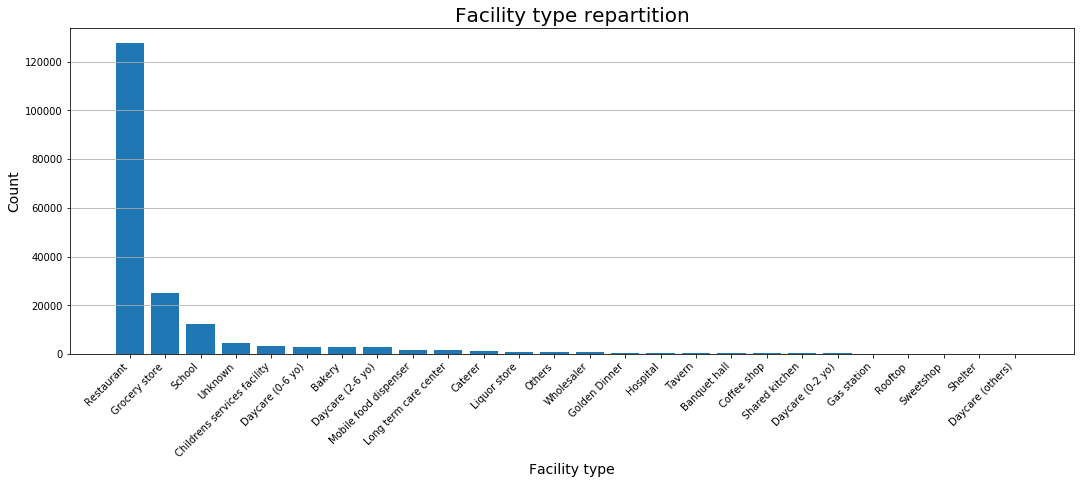

In [6]:
facility_types_count = dataset['Facility Type'].value_counts()
plt.figure(figsize=(18, 6))
plt.title('Facility type repartition', fontsize = 20)
plt.xlabel('Facility type', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(axis='y')
bar = plt.bar(x=facility_types_count.index, height=facility_types_count.values)

Most of the facilities are restaurant, grocery store and schools.  
Maybe our analysis should focus only on these 3 (or even just restaurants and stores)?

### Risk repartition

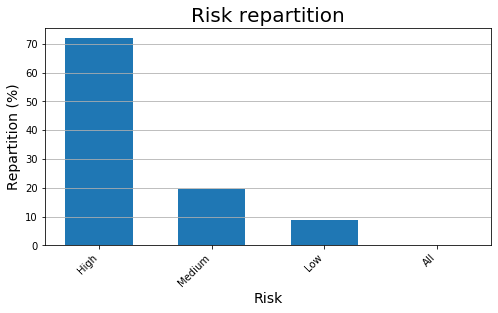

In [7]:
count = dataset['Risk'].count()
facility_types_count = dataset['Risk'].value_counts() * 100 / count
plt.figure(figsize=(8, 4))
plt.grid(axis='y')
plt.title('Risk repartition', fontsize = 20)
plt.xlabel('Risk', fontsize = 14)
plt.ylabel('Repartition (%)', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right')
bar = plt.bar(x=facility_types_count.index, height=facility_types_count.values, width=0.6)

Among the 3 biggest facility types:

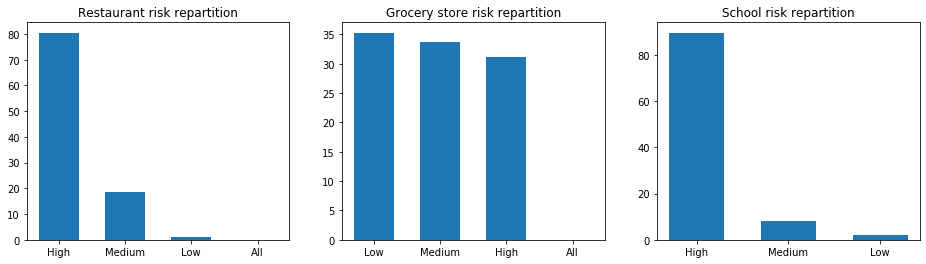

In [8]:
types = ['Restaurant', 'Grocery store', 'School']
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i, ftype in enumerate(types):
    count = dataset[dataset['Facility Type'] == ftype]['Risk'].count()
    facility_risk_count = dataset[dataset['Facility Type'] == ftype]['Risk'].value_counts() * 100 / count
    axs[i].bar(x=facility_risk_count.index, height=facility_risk_count.values, width=0.6)
    axs[i].set_title('{} risk repartition'.format(ftype))


It seems that places where food is prepared and served are more likely to be classified as high-risk.  
Whereas grocery store are more uniformly distributed.

### Violations repartition

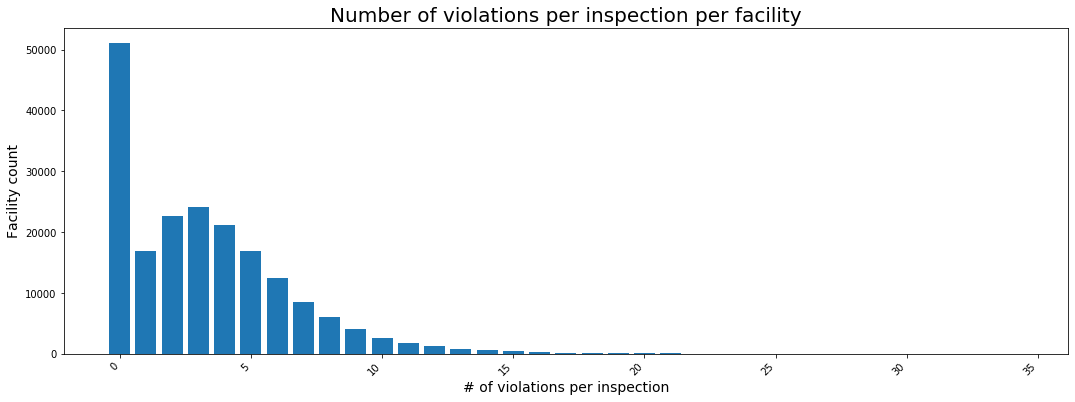

In [9]:
facility_types_count = dataset['Nb Violations'].value_counts()
plt.figure(figsize=(18, 6))
plt.title('Number of violations per inspection per facility', fontsize = 20)
plt.xlabel('# of violations per inspection', fontsize = 14)
plt.ylabel('Facility count', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right')
bar = plt.bar(x=facility_types_count.index, height=facility_types_count.values)

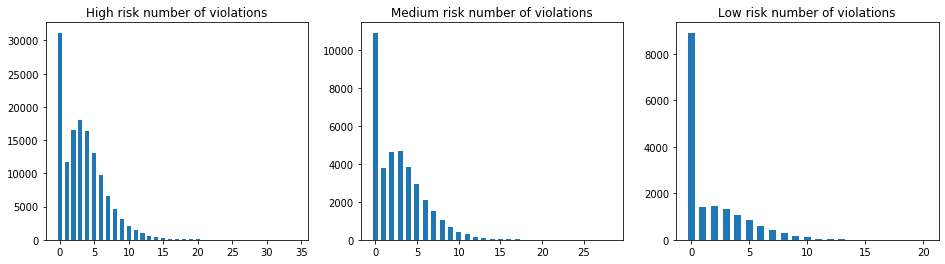

In [10]:
risks = ['High', 'Medium', 'Low']
risks_violations = [dataset[dataset['Risk'] == rtype]['Nb Violations'].value_counts() for rtype in risks]

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i, rtype in enumerate(risks):
    axs[i].bar(x=risks_violations[i].index, height=risks_violations[i].values, width=0.6)
    axs[i].set_title('{} risk number of violations'.format(rtype))

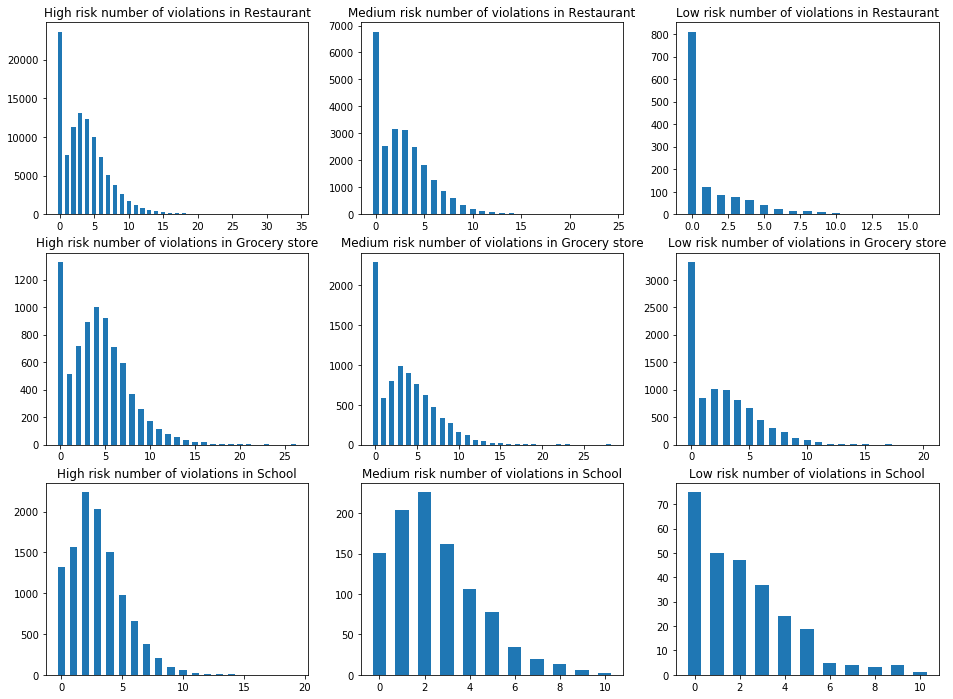

In [13]:
rtypes = ['High', 'Medium', 'Low']
ftypes = ['Restaurant', 'Grocery store', 'School']

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for i, ftype in enumerate(ftypes):
    for j, rtype in enumerate(rtypes):
        risks_violations = dataset[(dataset['Risk'] == rtype) & (dataset['Facility Type'] == ftype)]['Nb Violations'].value_counts()
        axs[i, j].bar(x=risks_violations.index, height=risks_violations.values, width=0.6)
        axs[i, j].set_title('{} risk number of violations in {}'.format(rtype, ftype))

# III] Zip-centered analysis

## 1) With the number of violations

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from bs4 import BeautifulSoup
import requests
%matplotlib inline

### Load resources

In [189]:
path = 'resources/extended_dataset.parquet'
df = pd.read_parquet(path)
df.head(2)

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   

  Inspection Type  ... Re-inspection       Community            Neighborhood  \
0       Complaint  ...          True     ALBANY PARK  NORTH PARK,ALBANY PARK   
1         License  ...          True  LINCOLN SQUARE          LINCOLN SQUARE   

   Ward  Precinct                   Violation IDs Nb Violations  \
0    33        27                          [None]             0   
1    47        38  [3, 5, 25, 50, 53, 53, 56, 58]             8   

  Nb Violations of high severity Nb Violations of medium severity  \
0                              0                                0   
1                              2                                1   

  Nb Violations of low severity  
0                             0  
1                             5  

[2 rows x 24 columns]

### Some cleaning

In [190]:
count_by_zip = df[['Zip', 'Inspection ID']].groupby('Zip').count().rename(columns={'Inspection ID' : 'Count'}).sort_values('Count')
count_by_zip.head(10)

Count
Zip         
60148      1
60559      1
60627      2
60501      4
60666     25
0         47
60827    134
60633    341
60655    794
60656    810

We remove the zip codes where we have too few inspections to have significative results.

In [192]:
df_filtered = df_filtered[(df_filtered['Zip'] != 60148) & (df_filtered['Zip'] != 60559) & (df_filtered['Zip'] != 60627) & (df_filtered['Zip'] != 60501) & (df_filtered['Zip'] != 60666) & (df_filtered['Zip'] != 0)]

### Scraping online data about zip codes

We remove the zip code '0' and also the ones we know we cannot find on the website we scrap

In [193]:
zip_codes = np.sort(df_filtered['Zip'].unique())
zip_codes

array([60601, 60602, 60603, 60604, 60605, 60606, 60607, 60608, 60609,
       60610, 60611, 60612, 60613, 60614, 60615, 60616, 60617, 60618,
       60619, 60620, 60621, 60622, 60623, 60624, 60625, 60626, 60628,
       60629, 60630, 60631, 60632, 60633, 60634, 60636, 60637, 60638,
       60639, 60640, 60641, 60642, 60643, 60644, 60645, 60646, 60647,
       60649, 60651, 60652, 60653, 60654, 60655, 60656, 60657, 60659,
       60660, 60661, 60707, 60827])

In [198]:
try:
    df_zip_codes = pd.read_parquet('resources/zip_infos.parquet')
except:
    population_densities = []
    diversity_indexes = []
    median_household_incomes = []
    per_capita_incomes = []
    wealth_indexes = []

    for i, zip_code in enumerate(zip_codes):
        URL = 'https://illinois.hometownlocator.com/zip-codes/data,zipcode,{}.cfm'.format(zip_code)
        r = requests.get(URL)
        page_body = r.text
        soup = BeautifulSoup(page_body, 'html.parser')
        all_tables = soup.find_all('table')
        for table in all_tables:
            all_tr = table.find_all('tr')
            for tr in all_tr:
                all_td = tr.find_all('td')
                if len(all_td) >= 2:
                    if all_td[0].text == 'Population Density':
                        population_density = all_td[1].text.replace(',', '.')
                        population_densities.append(population_density)
                    if all_td[0].text == 'Diversity Index1':
                        diversity_index = all_td[1].text
                        diversity_indexes.append(diversity_index)
                    if all_td[0].text == 'Median Household Income' and not all_td[1].text.startswith('#'):
                        median_household_income = all_td[1].text[1:].replace(',', '.')
                        if median_household_income != '':
                            median_household_incomes.append(median_household_income)
                    if all_td[0].text == 'Per Capita Income' and not all_td[1].text.startswith('#'):
                        per_capita_income = all_td[1].text[1:].replace(',', '.')
                        if per_capita_income != '':
                            per_capita_incomes.append(per_capita_income)
                    if all_td[0].text == 'Wealth Index3':
                        wealth_index = all_td[1].text
                        wealth_indexes.append(wealth_index)

    dict_ = {'Zip' : zip_codes, 'Diversity index' : diversity_indexes, 'Median household income' : median_household_incomes, 'Per capita income' : per_capita_incomes, 'Wealth index' : wealth_indexes}
    df_zip_codes = pd.DataFrame(dict_, dtype=float).set_index('Zip')
    
df_zip_codes.head()

Diversity index  Median household income  Per capita income  \
Zip                                                                    
60601.0             60.0                  112.683             91.269   
60602.0             57.0                  100.105             71.987   
60603.0             61.0                  123.197             84.558   
60604.0             60.0                  132.745            125.745   
60605.0             64.0                  102.573             73.803   

         Wealth index  
Zip                    
60601.0         120.0  
60602.0         116.0  
60603.0         174.0  
60604.0         193.0  
60605.0         127.0

### Save the collected data

In [199]:
df_zip_codes.to_parquet('resources/zip_infos.parquet')

### Can we find a correlation between the number of violations and the zip code's quality of life?

In [201]:
mean_nb_violations_by_zip = df_filtered[['Zip', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Zip').mean()
mean_nb_violations_by_zip.head()

Nb Violations  Nb Violations of high severity  \
Zip                                                    
60601       2.533744                        0.229584   
60602       2.704045                        0.273243   
60603       2.442857                        0.241270   
60604       2.764158                        0.266874   
60605       2.782092                        0.335366   

       Nb Violations of medium severity  Nb Violations of low severity  
Zip                                                                     
60601                          0.197843                       2.106317  
60602                          0.205110                       2.225692  
60603                          0.238095                       1.963492  
60604                          0.197828                       2.299457  
60605                          0.296213                       2.150513

In [202]:
df_joined_nb_violations = mean_nb_violations_by_zip.join(df_zip_codes)
df_joined_nb_violations.head()

Nb Violations  Nb Violations of high severity  \
Zip                                                    
60601       2.533744                        0.229584   
60602       2.704045                        0.273243   
60603       2.442857                        0.241270   
60604       2.764158                        0.266874   
60605       2.782092                        0.335366   

       Nb Violations of medium severity  Nb Violations of low severity  \
Zip                                                                      
60601                          0.197843                       2.106317   
60602                          0.205110                       2.225692   
60603                          0.238095                       1.963492   
60604                          0.197828                       2.299457   
60605                          0.296213                       2.150513   

       Diversity index  Median household income  Per capita income  \
Zip                                                                  
60601             60.0                  112.683             91.269   
60602             57.0                  100.105             71.987   
60603             61.0                  123.197             84.558   
60604             60.0                  132.745            125.745   
60605             64.0                  102.573             73.803   

       Wealth index  
Zip                  
60601         120.0  
60602         116.0  
60603         174.0  
60604         193.0  
60605         127.0

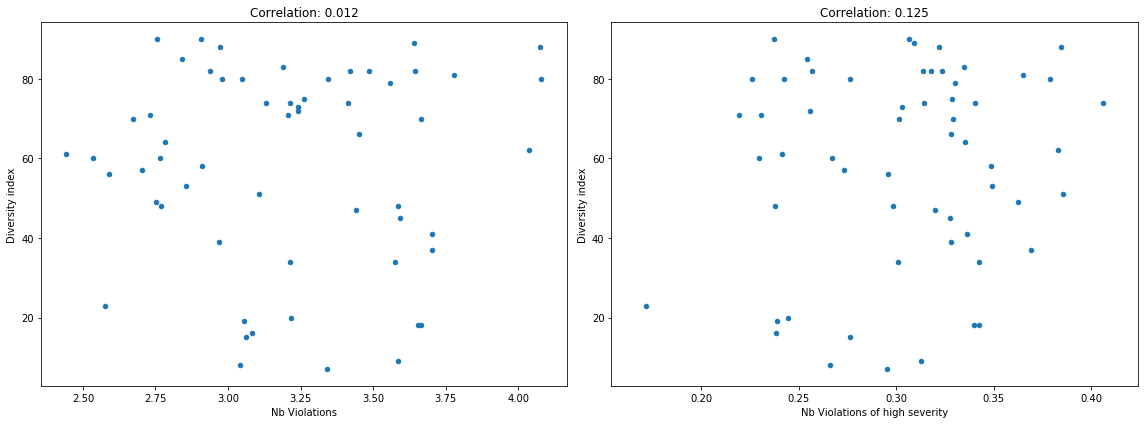

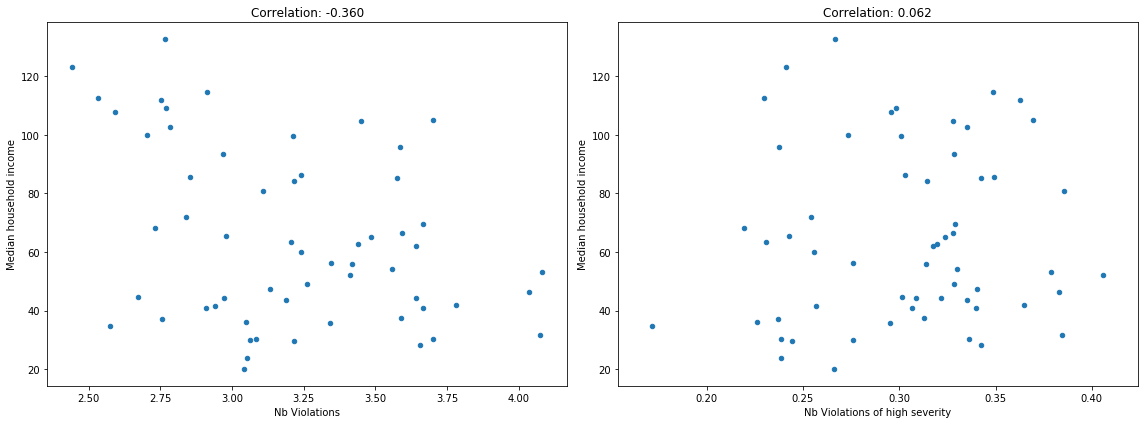

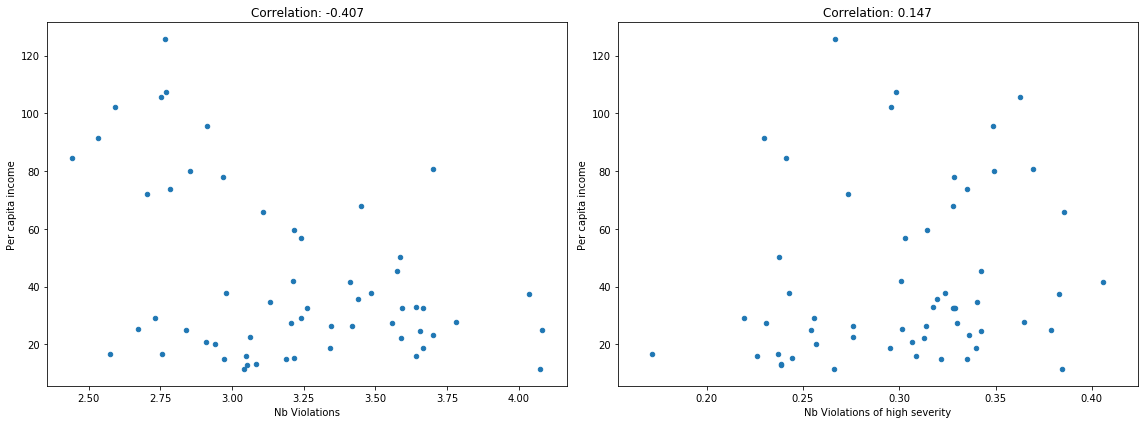

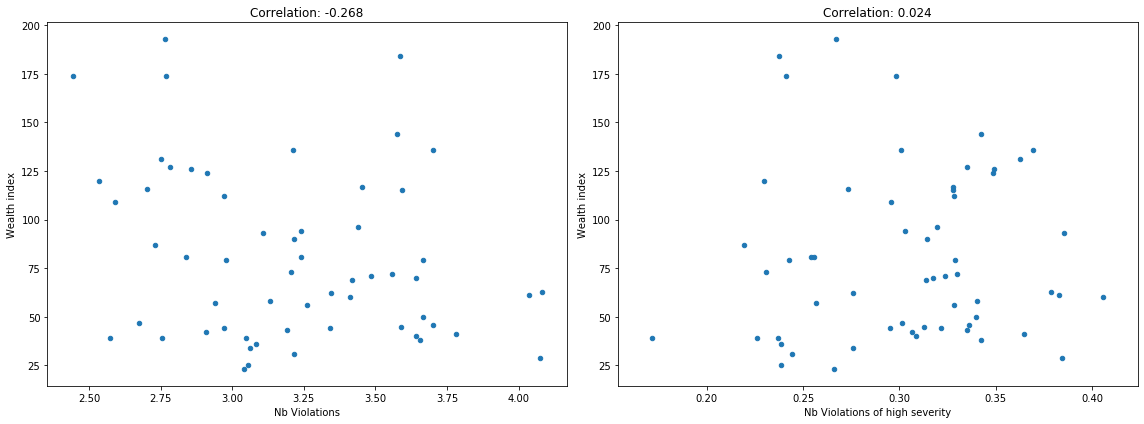

In [203]:
for column_name1 in df_zip_codes.columns:
    fig, ax = plt.subplots(1, len(mean_nb_violations_by_zip.columns[:2]), figsize=(16,6))
    
    for i, column_name2 in enumerate(mean_nb_violations_by_zip.columns[:2]):
        df_joined_nb_violations[[column_name2, column_name1]].plot.scatter(x=column_name2, y=column_name1, ax=ax[i])
        ax[i].set_title('Correlation: {}'.format("%.3f" % df_joined_nb_violations[column_name2].corr(df_joined_nb_violations[column_name1])))
    
    plt.tight_layout()
    plt.show()

We find no particular correlation.

### Same as before, but between number of pass/fail inspections and zip

In [204]:
results_by_zip = df_filtered[['Zip', 'Results']]
results_by_zip['Pass'] = results_by_zip['Results'].apply(lambda x: 1 if x == 'Pass' else 0)
results_by_zip['Pass w/ Conditions'] = results_by_zip['Results'].apply(lambda x: 1 if x == 'Pass w/ Conditions' else 0)
results_by_zip['Fail'] = results_by_zip['Results'].apply(lambda x: 1 if x == 'Fail' else 0)
results_by_zip = results_by_zip.groupby('Zip').mean()
results_by_zip.head()

/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Pass  Pass w/ Conditions      Fail
Zip                                          
60601  0.655162            0.136210  0.125732
60602  0.644429            0.137686  0.141945
60603  0.614815            0.150794  0.146032
60604  0.619085            0.145074  0.126455
60605  0.572208            0.145058  0.163992

In [205]:
df_joined_results = results_by_zip.join(df_zip_codes)
df_joined_results.head()

Pass  Pass w/ Conditions      Fail  Diversity index  \
Zip                                                              
60601  0.655162            0.136210  0.125732             60.0   
60602  0.644429            0.137686  0.141945             57.0   
60603  0.614815            0.150794  0.146032             61.0   
60604  0.619085            0.145074  0.126455             60.0   
60605  0.572208            0.145058  0.163992             64.0   

       Median household income  Per capita income  Wealth index  
Zip                                                              
60601                  112.683             91.269         120.0  
60602                  100.105             71.987         116.0  
60603                  123.197             84.558         174.0  
60604                  132.745            125.745         193.0  
60605                  102.573             73.803         127.0

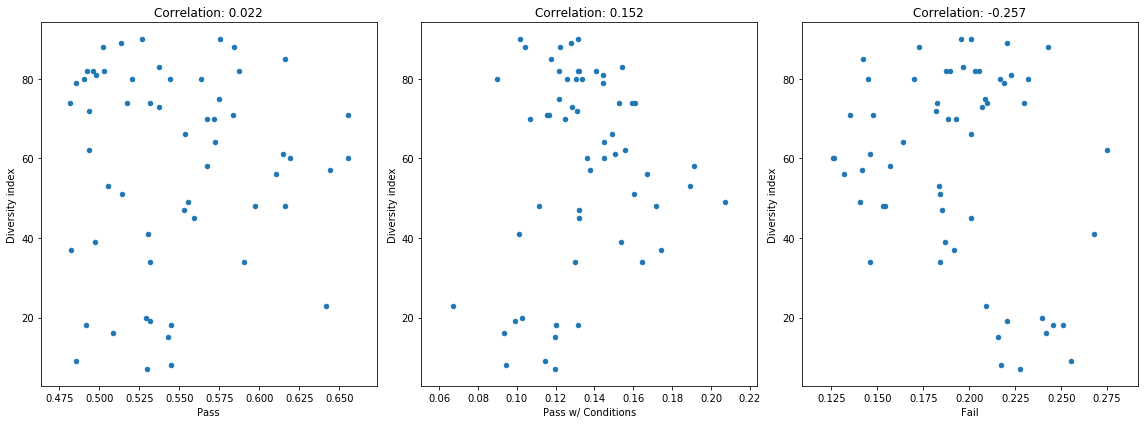

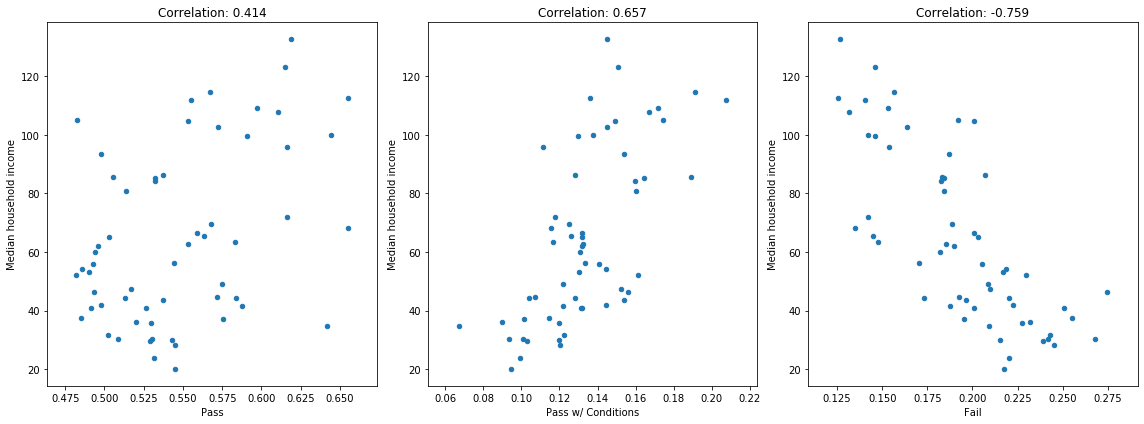

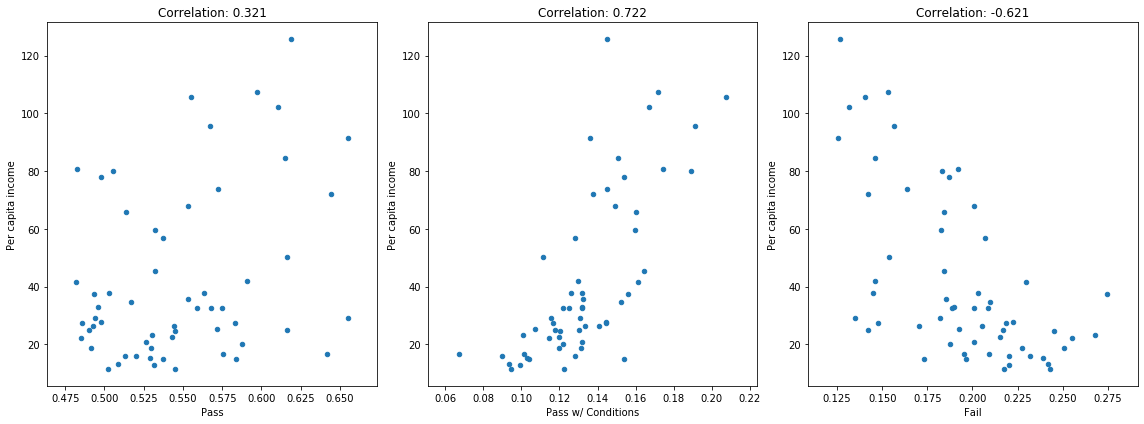

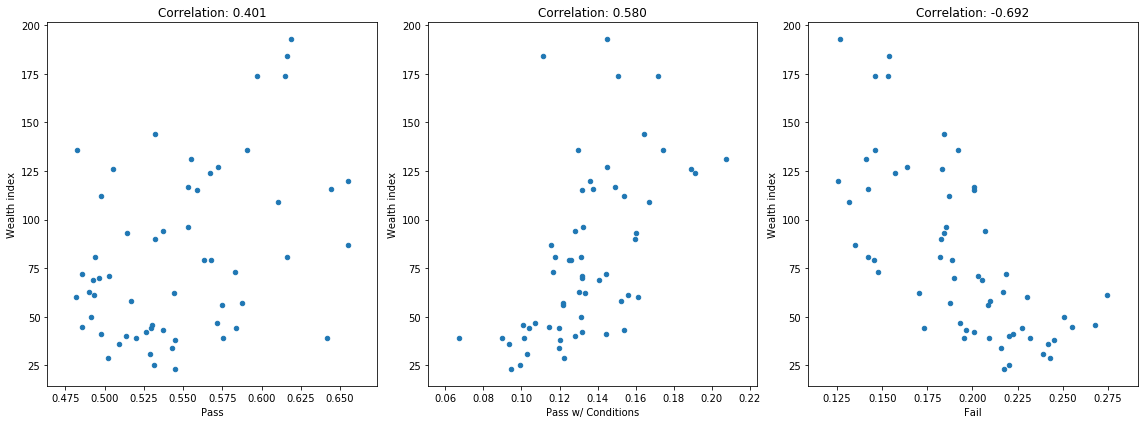

In [206]:
for column_name1 in df_zip_codes.columns:
    fig, ax = plt.subplots(1, len(results_by_zip.columns), figsize=(16,6))
    for i, column_name2 in enumerate(results_by_zip.columns):
        df_joined_results[[column_name2, column_name1]].plot.scatter(x=column_name2, y=column_name1, ax=ax[i])
        ax[i].set_title('Correlation: {}'.format("%.3f" % df_joined_results[column_name2].corr(df_joined_results[column_name1])))

    plt.tight_layout()
    plt.show()

We found some intersting correlation, especially with the household income, the per capita income and the wealth degree (which are surely already correlated between them).

## 2) With some stats about the inspections

In [2]:
import pandas as pd
import folium as fo
import numpy as np
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)

We will use the data from the Chicago website to find if there are some correlation between common stats of the dataset and Chicago's demographics.  
We first keep only the relevant columns and aggregate them after a groupBy on the zips.

In [3]:
dataset = pd.read_parquet('resources/extended_dataset.parquet').astype({'Zip':'int32'})
zips = pd.read_parquet('resources/zip_infos.parquet')

with open('resources/geojsons/chicago-zip.geojson') as f0:
    chicago_zips = json.load(f0)

In [4]:
available_zips = []
for feature in chicago_zips['features']:
    available_zips.append(feature['properties']['zip'])
filtered_zip_dataset = dataset[dataset['Zip'].isin(available_zips)]
filtered_zip_dataset['Inspections'] = 1
filtered_zip_dataset['Results'] = (filtered_zip_dataset['Results'] == 'Fail')

In [5]:
col_to_drop = ['Inspection ID', 'License #', 'Latitude', 'Longitude']
col_rename = {'Results': 'fails', 'Re-inspection': 'reinspections', 'Inspections':'inspections', 'Nb Violations': 'violations', 'Nb Violations of high severity': 'high', 'Nb Violations of medium severity': 'medium', 'Nb Violations of low severity': 'low'}
index_rename = {'Zip': 'zip'}
col_order = ['inspections', 'fails', 'reinspections', 'violations', 'high', 'medium', 'low']

agg_zip_dataset = filtered_zip_dataset.groupby(by='Zip').agg(sum).drop(col_to_drop, axis=1).rename(columns=col_rename, index=index_rename)[col_order].astype({'reinspections':'int64', 'fails':'int64'})
agg_zip_dataset.head()

inspections  fails  reinspections  violations  high  medium   low
Zip                                                                     
60601         3245    408            414        8222   745     642  6835
60602         1409    200            187        3810   385     289  3136
60603         1890    276            273        4617   456     450  3711
60604         1289    163            173        3563   344     255  2964
60605         3116    511            510        8669  1045     923  6701

Then we create the basic statistics that we will compare to the Chicago's zip demographics

In [6]:
stats_zip_dataset = agg_zip_dataset.copy()
stats_zip_dataset['high'] = stats_zip_dataset.high / stats_zip_dataset.violations
stats_zip_dataset['medium'] = stats_zip_dataset.medium / stats_zip_dataset.violations
stats_zip_dataset['low'] = stats_zip_dataset.low / stats_zip_dataset.violations
stats_zip_dataset['inspection_fail_rate'] = stats_zip_dataset.fails / stats_zip_dataset.inspections
stats_zip_dataset['inspection_viol'] = stats_zip_dataset.violations / stats_zip_dataset.inspections
stats_zip_dataset['reinspection_viol'] = stats_zip_dataset.violations / stats_zip_dataset.reinspections
col_to_drop = ['inspections', 'fails', 'reinspections', 'violations']
stats_zip_dataset = stats_zip_dataset.drop(col_to_drop, axis=1)
stats_zip_dataset.head(5)

high    medium       low  inspection_fail_rate  inspection_viol  \
Zip                                                                          
60601  0.090611  0.078083  0.831306              0.125732         2.533744   
60602  0.101050  0.075853  0.823097              0.141945         2.704045   
60603  0.098765  0.097466  0.803769              0.146032         2.442857   
60604  0.096548  0.071569  0.831883              0.126455         2.764158   
60605  0.120544  0.106471  0.772984              0.163992         2.782092   

       reinspection_viol  
Zip                       
60601          19.859903  
60602          20.374332  
60603          16.912088  
60604          20.595376  
60605          16.998039

In [7]:
col_to_rename = {'Diversity index': 'diversity', 'Median household income': 'household_income', 'Per capita income': 'capita_income', 'Wealth index': 'wealth'}
new_zips = zips.copy().astype({'Wealth index': 'int64', 'Diversity index': 'int64'}).rename(columns=col_to_rename)
new_zips.index = new_zips.index.astype('int64')

print(new_zips.shape)
print(stats_zip_dataset.shape)
t = new_zips.index.values
#print(len(.inter(stats_zip_dataset.index.values)))

(58, 4)
(59, 6)


One zip code isn't in both dataframe so we remove it.

In [8]:
zip1 = set(new_zips.index.values.tolist())
zip2 = set(stats_zip_dataset.index.values.tolist())
inter_zip = set([x for x in zip1.intersection(zip2)])

df1 = new_zips[new_zips.index.isin(inter_zip)]
df2 = stats_zip_dataset[stats_zip_dataset.index.isin(inter_zip)]

Then we compute the correlations and only keep the interesting pair (we don't want another analysis of Chicago's demographics).

In [9]:
col_to_keep = stats_zip_dataset.columns
row_to_keep = new_zips.columns

correlations = stats_zip_dataset.join(new_zips).corr()[col_to_keep].unstack().reset_index(name='corr').rename(columns={'level_0':'cfi', 'level_1': 'dem'})
correlations = correlations[correlations.dem.isin(row_to_keep)].sort_values(by='corr')
correlations.sort_values(by='corr')

cfi               dem      corr
37  inspection_fail_rate  household_income -0.759257
39  inspection_fail_rate            wealth -0.692026
38  inspection_fail_rate     capita_income -0.621443
48       inspection_viol     capita_income -0.407216
47       inspection_viol  household_income -0.360064
28                   low     capita_income -0.316159
19                medium            wealth -0.309107
17                medium  household_income -0.284688
49       inspection_viol            wealth -0.267849
36  inspection_fail_rate         diversity -0.257290
16                medium         diversity -0.205328
27                   low  household_income -0.110454
18                medium     capita_income -0.088144
29                   low            wealth -0.016523
46       inspection_viol         diversity  0.012049
26                   low         diversity  0.029865
6                   high         diversity  0.134870
56     reinspection_viol         diversity  0.281881
9                   high            wealth  0.296606
58     reinspection_viol     capita_income  0.312178
7                   high  household_income  0.418113
8                   high     capita_income  0.558564
57     reinspection_viol  household_income  0.564643
59     reinspection_viol            wealth  0.591263

### The biggest correlation  
From the correlation tab, we found out that the inspection fail rate may be related the median household income (and thus also the wealth) with a pretty high negative correlation.    
We will print the two different stats on a map to compare them.  
  

### /!\ if looking at this from a rendered notebook (ie Github) the displayable maps are in resources/zip-... /!\

In [10]:
m1 = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
nds = pd.DataFrame()
nds['zip'] = stats_zip_dataset.index.astype('str')
nds['ratio'] = stats_zip_dataset['inspection_fail_rate'].values * 100
fe1 = fo.Choropleth(
    geo_data='resources/geojsons/chicago-zip.geojson',
    name='Fail rate',
    data=nds,
    columns=['zip', 'ratio'],
    key_on='properties.zip',
    fill_color='Reds',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Inspection fail rate (in %)'
)
fe1.add_to(m1)

m2 = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
nds = pd.DataFrame()
nds['zip'] = new_zips.index.astype('str')
nds['ratio'] = new_zips['household_income'].values
fe2 = fo.Choropleth(
    geo_data=chicago_zips,
    name='Household income',
    data=nds,
    columns=['zip','ratio'],
    key_on='properties.zip',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Household Income',
)
fe2.add_to(m2)
m1.save(outfile='results/zip-inpection-fail-rate.html')
m2.save(outfile='results/zip-household-income.html')
fe2.add_to(m1)
fo.LayerControl(collapsed=False, position='bottomright').add_to(m1)
m1

We clearly see that places where people have a low income also are the ones with the highest inspection fail.  

# IV] Community-centered 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
%matplotlib inline

### Load resources

In [17]:
path = 'resources/extended_dataset.parquet'
df = pd.read_parquet(path)
df.head(2)

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   

  Inspection Type  ... Re-inspection       Community            Neighborhood  \
0       Complaint  ...          True     ALBANY PARK  NORTH PARK,ALBANY PARK   
1         License  ...          True  LINCOLN SQUARE          LINCOLN SQUARE   

   Ward  Precinct                   Violation IDs Nb Violations  \
0    33        27                          [None]             0   
1    47        38  [3, 5, 25, 50, 53, 53, 56, 58]             8   

  Nb Violations of high severity Nb Violations of medium severity  \
0                              0                                0   
1                              2                                1   

  Nb Violations of low severity  
0                             0  
1                             5  

[2 rows x 24 columns]

In [18]:
community_areas = pd.read_csv('resources/community_areas_infos.csv', delimiter=',').set_index('Community')
community_areas.index = community_areas.index.str.upper()
community_areas.head()

Community Area Number  Percent of housing crowded  \
Community                                                           
ROGERS PARK                       1.0                         7.7   
WEST RIDGE                        2.0                         7.8   
UPTOWN                            3.0                         3.8   
LINCOLN SQUARE                    4.0                         3.4   
NORTH CENTER                      5.0                         0.3   

                Percent households below poverty  Percent aged 16+ unemployed  \
Community                                                                       
ROGERS PARK                                 23.6                          8.7   
WEST RIDGE                                  17.2                          8.8   
UPTOWN                                      24.0                          8.9   
LINCOLN SQUARE                              10.9                          8.2   
NORTH CENTER                                 7.5                          5.2   

                Percent aged 25+ without high school diploma  \
Community                                                      
ROGERS PARK                                             18.2   
WEST RIDGE                                              20.8   
UPTOWN                                                  11.8   
LINCOLN SQUARE                                          13.4   
NORTH CENTER                                             4.5   

                Percent aged under 18 or over 64  Per capita income  \
Community                                                             
ROGERS PARK                                 27.5              23939   
WEST RIDGE                                  38.5              23040   
UPTOWN                                      22.2              35787   
LINCOLN SQUARE                              25.5              37524   
NORTH CENTER                                26.2              57123   

                Hardship index  
Community                       
ROGERS PARK               39.0  
WEST RIDGE                46.0  
UPTOWN                    20.0  
LINCOLN SQUARE            17.0  
NORTH CENTER               6.0

### Some filtering

In [19]:
count_by_community = df[['Community', 'Inspection ID']].groupby('Community').count().rename(columns={'Inspection ID' : 'Count'}).sort_values('Count')
count_by_community.head(10)

Count
Community         
BURNSIDE        20
OAKLAND         48
RIVERDALE      183
PULLMAN        294
FULLER PARK    358
HEGEWISCH      447
OHARE          500
AVALON PARK    560
MONTCLARE      611
KENWOOD        617

We remove the communities that have only a few inspections because they could bias our analysis.

In [20]:
df_filtered = df[(df['Community'] != 'BURNSIDE') & (df['Community'] != 'OAKLAND')]

### Can we find correlations between the number of violations by community and their life level?

In [21]:
mean_nb_violations_by_community = df_filtered[['Community', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Community').mean()
mean_nb_violations_by_community.head()

Nb Violations  Nb Violations of high severity  \
Community                                                       
ALBANY PARK          3.516401                        0.325109   
ARCHER HEIGHTS       3.185700                        0.346574   
ARMOUR SQUARE        3.578030                        0.380303   
ASHBURN              2.854296                        0.250311   
AUBURN GRESHAM       3.190850                        0.271895   

                Nb Violations of medium severity  \
Community                                          
ALBANY PARK                             0.294049   
ARCHER HEIGHTS                          0.324727   
ARMOUR SQUARE                           0.308712   
ASHBURN                                 0.220423   
AUBURN GRESHAM                          0.299782   

                Nb Violations of low severity  
Community                                      
ALBANY PARK                          2.897242  
ARCHER HEIGHTS                       2.514399  
ARMOUR SQUARE                        2.889015  
ASHBURN                              2.383562  
AUBURN GRESHAM                       2.619172

In [22]:
df_joined_nb_violations = mean_nb_violations_by_community.join(community_areas)
df_joined_nb_violations.head()

Nb Violations  Nb Violations of high severity  \
Community                                                       
ALBANY PARK          3.516401                        0.325109   
ARCHER HEIGHTS       3.185700                        0.346574   
ARMOUR SQUARE        3.578030                        0.380303   
ASHBURN              2.854296                        0.250311   
AUBURN GRESHAM       3.190850                        0.271895   

                Nb Violations of medium severity  \
Community                                          
ALBANY PARK                             0.294049   
ARCHER HEIGHTS                          0.324727   
ARMOUR SQUARE                           0.308712   
ASHBURN                                 0.220423   
AUBURN GRESHAM                          0.299782   

                Nb Violations of low severity  Community Area Number  \
Community                                                              
ALBANY PARK                          2.897242                   14.0   
ARCHER HEIGHTS                       2.514399                   57.0   
ARMOUR SQUARE                        2.889015                   34.0   
ASHBURN                              2.383562                   70.0   
AUBURN GRESHAM                       2.619172                   71.0   

                Percent of housing crowded  Percent households below poverty  \
Community                                                                      
ALBANY PARK                           11.3                              19.2   
ARCHER HEIGHTS                         8.5                              14.1   
ARMOUR SQUARE                          5.7                              40.1   
ASHBURN                                4.0                              10.4   
AUBURN GRESHAM                         4.0                              27.6   

                Percent aged 16+ unemployed  \
Community                                     
ALBANY PARK                            10.0   
ARCHER HEIGHTS                         16.5   
ARMOUR SQUARE                          16.7   
ASHBURN                                11.7   
AUBURN GRESHAM                         28.3   

                Percent aged 25+ without high school diploma  \
Community                                                      
ALBANY PARK                                             32.9   
ARCHER HEIGHTS                                          35.9   
ARMOUR SQUARE                                           34.5   
ASHBURN                                                 17.7   
AUBURN GRESHAM                                          18.5   

                Percent aged under 18 or over 64  Per capita income  \
Community                                                             
ALBANY PARK                                 32.0            21323.0   
ARCHER HEIGHTS                              39.2            16134.0   
ARMOUR SQUARE                               38.3            16148.0   
ASHBURN                                     36.9            23482.0   
AUBURN GRESHAM                              41.9            15528.0   

                Hardship index  
Community                       
ALBANY PARK               53.0  
ARCHER HEIGHTS            67.0  
ARMOUR SQUARE             82.0  
ASHBURN                   37.0  
AUBURN GRESHAM            74.0

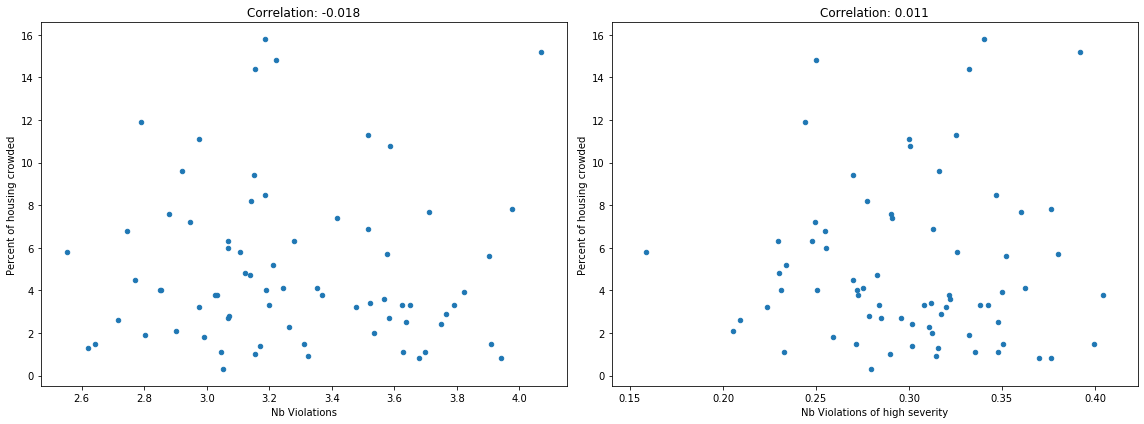

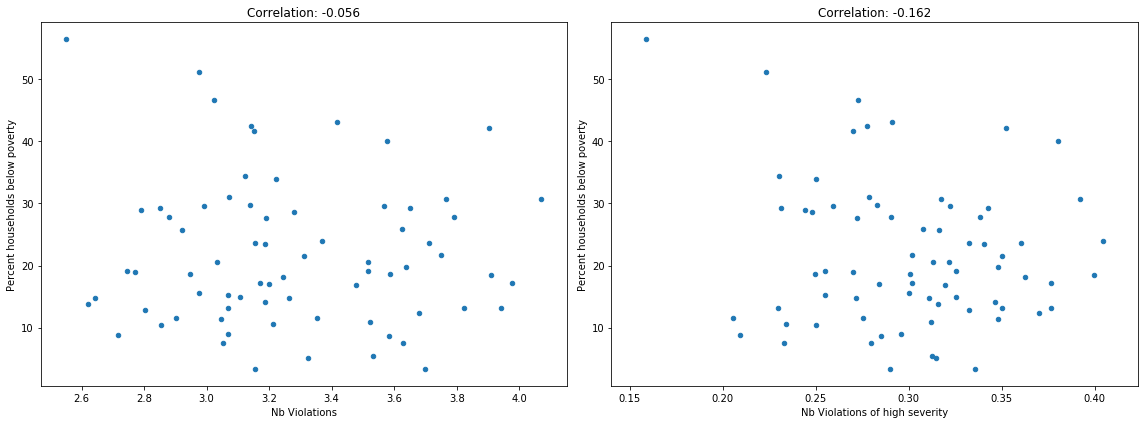

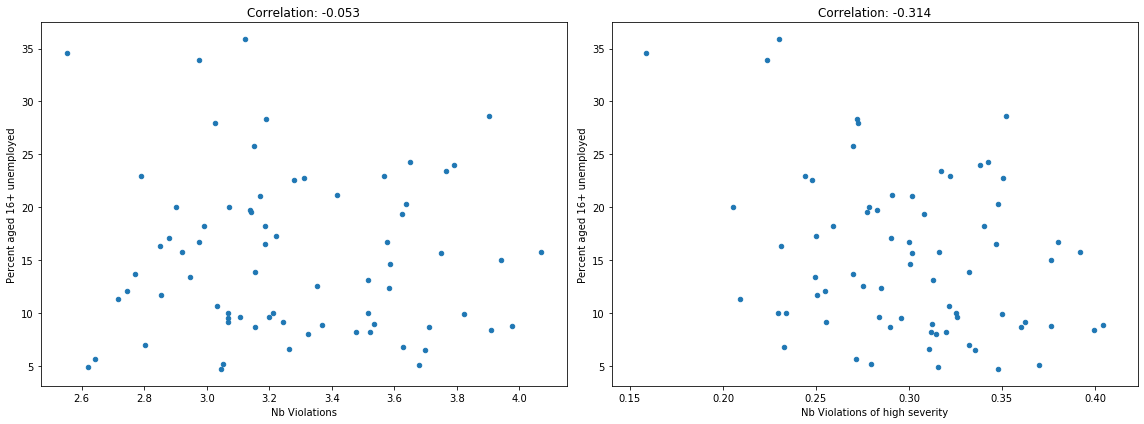

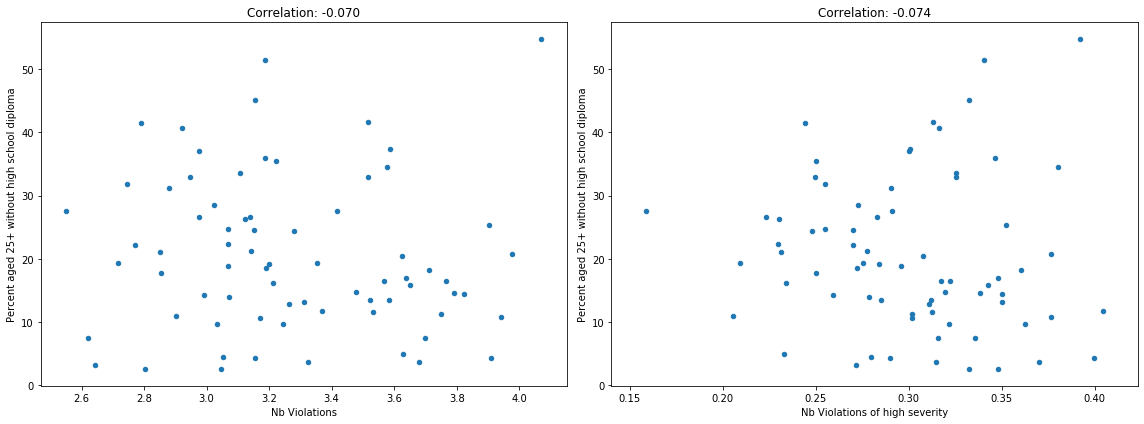

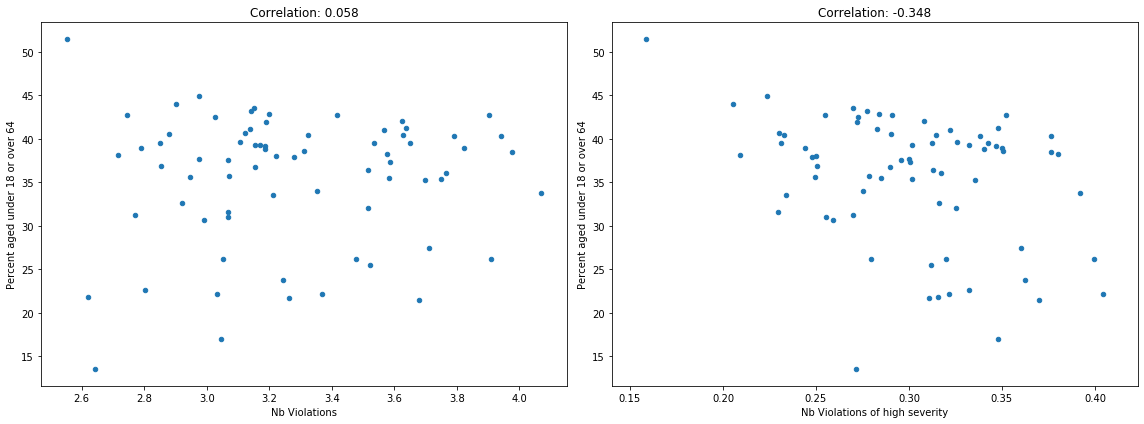

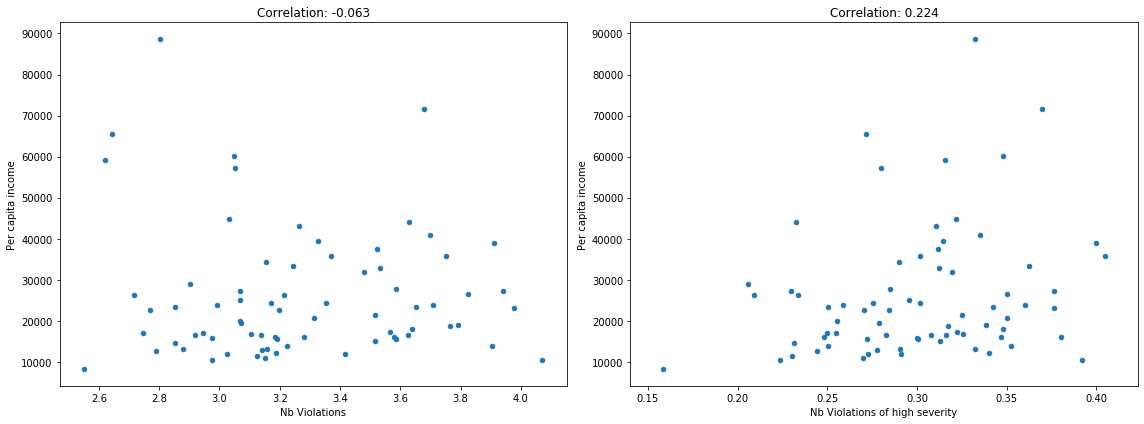

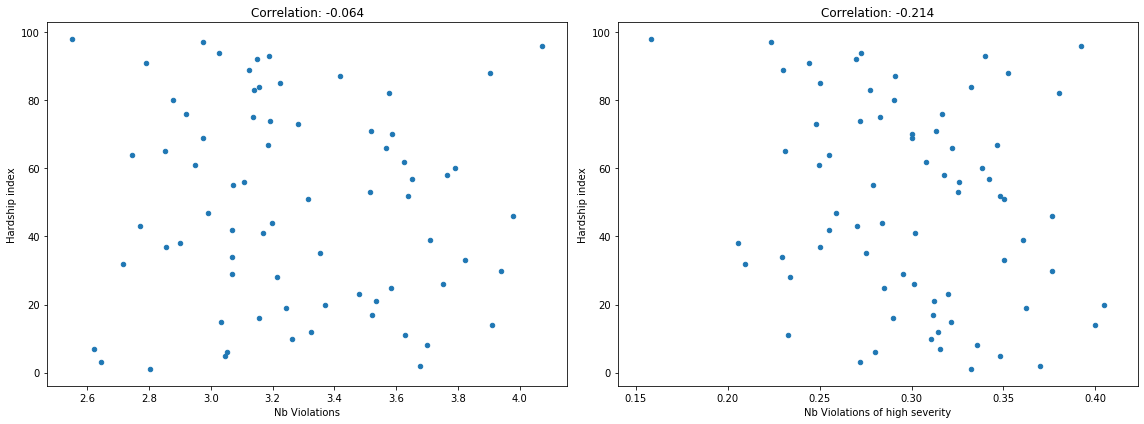

In [23]:
for column_name1 in community_areas.columns[1:]:
    fig, ax = plt.subplots(1, len(mean_nb_violations_by_community.columns[:2]), figsize=(16,6))
    
    for i, column_name2 in enumerate(mean_nb_violations_by_community.columns[:2]):
        df_joined_nb_violations[[column_name2, column_name1]].plot.scatter(x=column_name2, y=column_name1, ax=ax[i])
        ax[i].set_title('Correlation: {}'.format("%.3f" % df_joined_nb_violations[column_name2].corr(df_joined_nb_violations[column_name1])))
    
    plt.tight_layout()
    plt.show()

Sadly we have absolutly no correlation between the number of violations and the 'life levels' of the areas.

### Can we find correlations between the number of pass/fails by community and their life level?

In [24]:
results_by_community = df_filtered[['Community', 'Results']]
results_by_community['Pass'] = results_by_community['Results'].apply(lambda x: 1 if x == 'Pass' else 0)
results_by_community['Pass w/ Conditions'] = results_by_community['Results'].apply(lambda x: 1 if x == 'Pass w/ Conditions' else 0)
results_by_community['Fail'] = results_by_community['Results'].apply(lambda x: 1 if x == 'Fail' else 0)
results_by_community = results_by_community.groupby('Community').mean()
results_by_community.head()

/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Pass  Pass w/ Conditions      Fail
Community                                             
ALBANY PARK     0.496372            0.122496  0.194775
ARCHER HEIGHTS  0.541212            0.148957  0.192651
ARMOUR SQUARE   0.552273            0.121591  0.242803
ASHBURN         0.616438            0.118929  0.141345
AUBURN GRESHAM  0.520697            0.098911  0.234858

In [25]:
df_joined_results = results_by_community.join(community_areas)
df_joined_results.head()

Pass  Pass w/ Conditions      Fail  Community Area Number  \
Community                                                                       
ALBANY PARK     0.496372            0.122496  0.194775                   14.0   
ARCHER HEIGHTS  0.541212            0.148957  0.192651                   57.0   
ARMOUR SQUARE   0.552273            0.121591  0.242803                   34.0   
ASHBURN         0.616438            0.118929  0.141345                   70.0   
AUBURN GRESHAM  0.520697            0.098911  0.234858                   71.0   

                Percent of housing crowded  Percent households below poverty  \
Community                                                                      
ALBANY PARK                           11.3                              19.2   
ARCHER HEIGHTS                         8.5                              14.1   
ARMOUR SQUARE                          5.7                              40.1   
ASHBURN                                4.0                              10.4   
AUBURN GRESHAM                         4.0                              27.6   

                Percent aged 16+ unemployed  \
Community                                     
ALBANY PARK                            10.0   
ARCHER HEIGHTS                         16.5   
ARMOUR SQUARE                          16.7   
ASHBURN                                11.7   
AUBURN GRESHAM                         28.3   

                Percent aged 25+ without high school diploma  \
Community                                                      
ALBANY PARK                                             32.9   
ARCHER HEIGHTS                                          35.9   
ARMOUR SQUARE                                           34.5   
ASHBURN                                                 17.7   
AUBURN GRESHAM                                          18.5   

                Percent aged under 18 or over 64  Per capita income  \
Community                                                             
ALBANY PARK                                 32.0            21323.0   
ARCHER HEIGHTS                              39.2            16134.0   
ARMOUR SQUARE                               38.3            16148.0   
ASHBURN                                     36.9            23482.0   
AUBURN GRESHAM                              41.9            15528.0   

                Hardship index  
Community                       
ALBANY PARK               53.0  
ARCHER HEIGHTS            67.0  
ARMOUR SQUARE             82.0  
ASHBURN                   37.0  
AUBURN GRESHAM            74.0

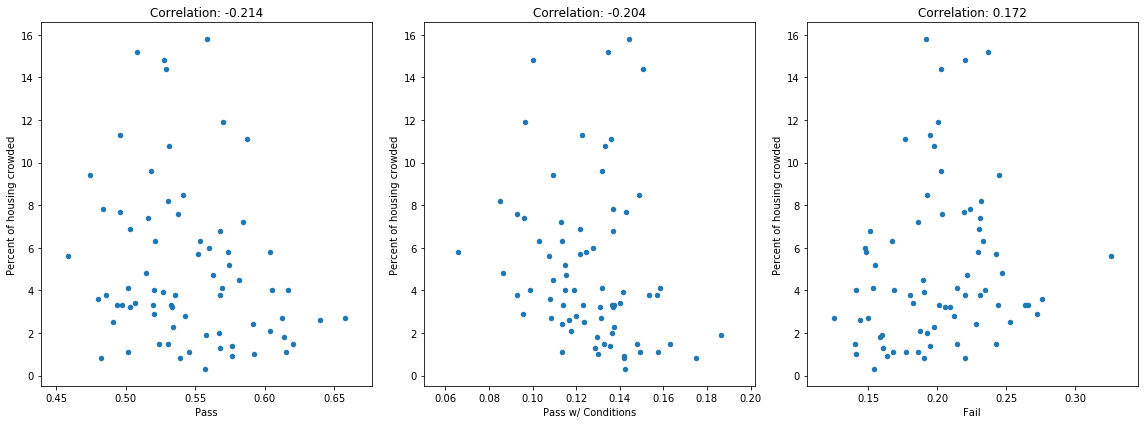

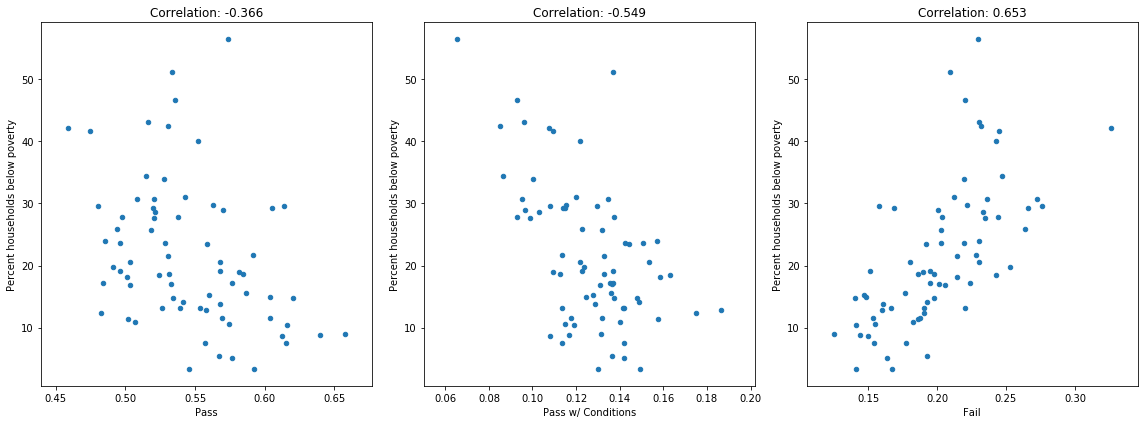

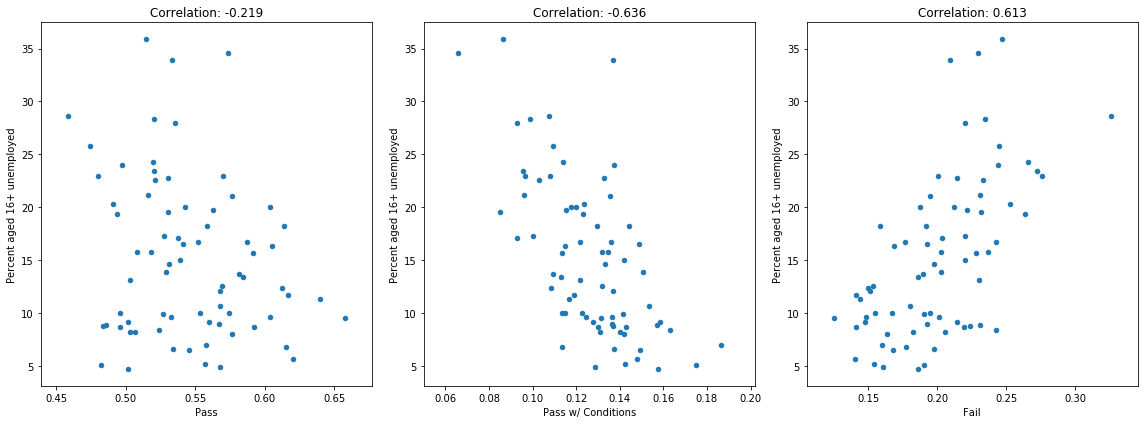

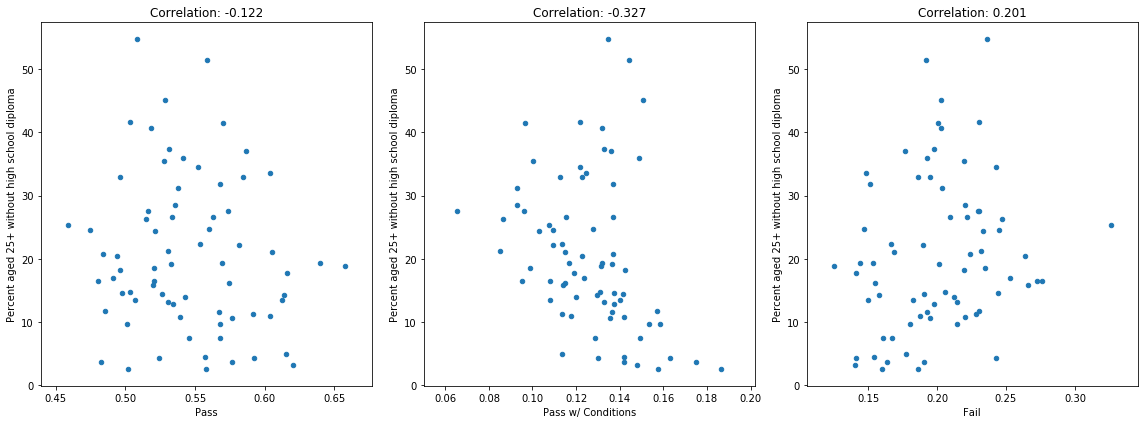

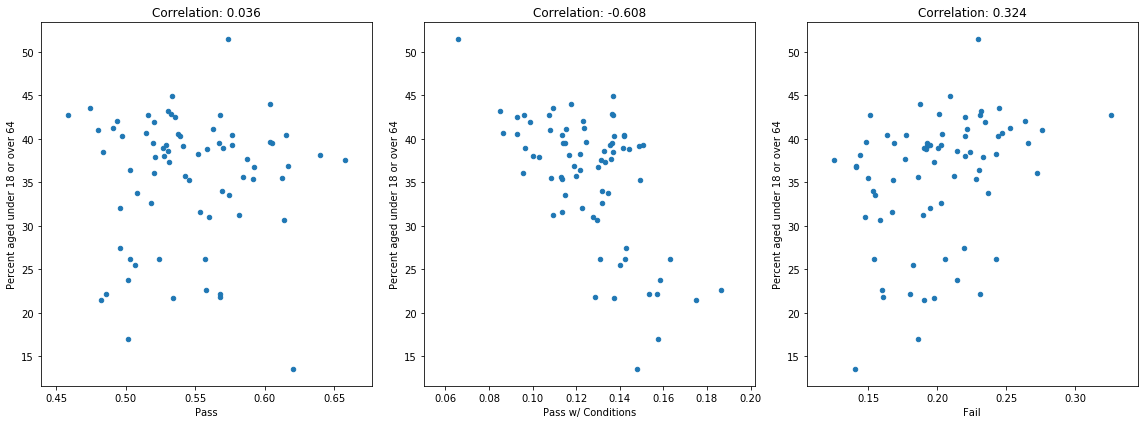

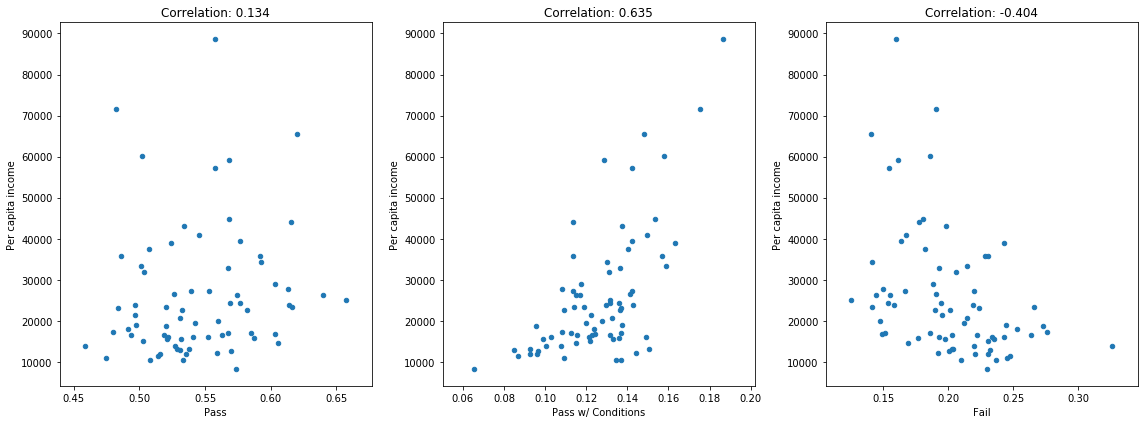

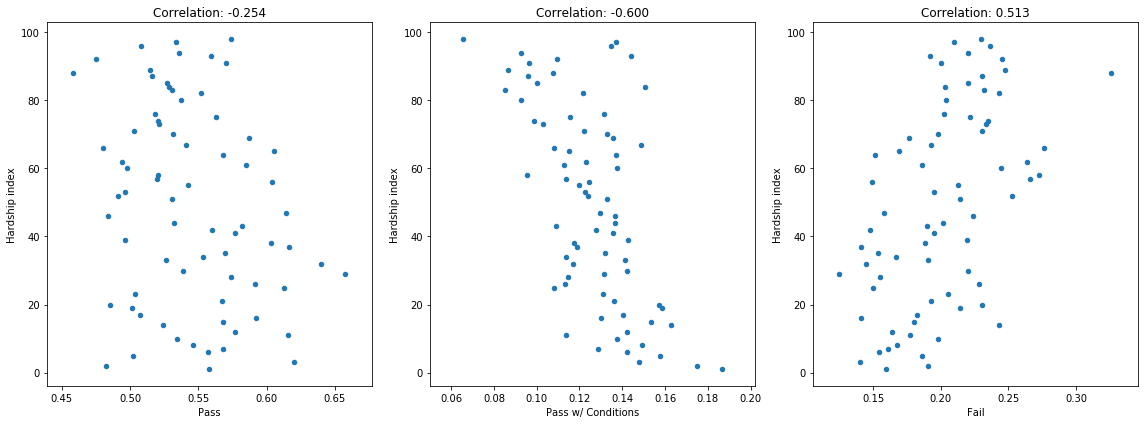

In [26]:
for column_name1 in community_areas.columns[1:]:
    fig, ax = plt.subplots(1, len(results_by_community.columns), figsize=(16,6))
    for i, column_name2 in enumerate(results_by_community.columns):
        df_joined_results[[column_name2, column_name1]].plot.scatter(x=column_name2, y=column_name1, ax=ax[i])
        ax[i].set_title('Correlation: {}'.format("%.3f" % df_joined_results[column_name2].corr(df_joined_results[column_name1])))

    plt.tight_layout()
    plt.show()

We have some slights correlations (~0.65) that are the same as before and are mostly income-based which seems to confirm our suspicions that low-income district may have more sanitary issues.

# V] Violations-based

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import folium as fo
import json
%matplotlib inline

### Load resources

In [56]:
path = 'resources/food-inspections-cleaned.parquet'
df = pd.read_parquet(path)
df.head(2)

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   

  Inspection Type Results                                         Violations  \
0       Complaint    Pass                                               None   
1         License    Fail  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   

    Latitude  Longitude  Re-inspection       Community  \
0  41.965719 -87.708538           True     ALBANY PARK   
1  41.968820 -87.682292           True  LINCOLN SQUARE   

             Neighborhood Ward Precinct  
0  NORTH PARK,ALBANY PARK   33       27  
1          LINCOLN SQUARE   47       38

In [57]:
nb_NaN_violations = len(df) - df['Violations'].count()
print("We have {} out of {} inspections with no violations recorded. It makes {}%.".format(nb_NaN_violations, len(df), "%.2f" % (nb_NaN_violations/len(df)*100)))

We have 51070 out of 191827 inspections with no violations recorded. It makes 26.62%.


### Explode violation

In [58]:
df_split = df.copy()
df_split['Violations'] = df_split['Violations'].map(lambda x: str(x).split('|'))
df_split.head(3)

Inspection ID            DBA Name            AKA Name  License #  \
0        2320519   SALAM  RESTAURANT    SALAM RESTAURANT    2002822   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
2        2320412  DANTE'S PIZZA,INC.       DANTE'S PIZZA    2092884   

  Facility Type  Risk                  Address    Zip Inspection Date  \
0    Restaurant  High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
1    Restaurant  High     2114 W LAWRENCE AVE   60625      2019-10-25   
2    Restaurant  High     3028 W ARMITAGE AVE   60647      2019-10-24   

  Inspection Type Results                                         Violations  \
0       Complaint    Pass                                             [None]   
1         License    Fail  [3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...   
2         Canvass    Fail  [38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...   

    Latitude  Longitude  Re-inspection       Community  \
0  41.965719 -87.708538           True     ALBANY PARK   
1  41.968820 -87.682292           True  LINCOLN SQUARE   
2  41.917539 -87.703728          False    LOGAN SQUARE   

             Neighborhood Ward Precinct  
0  NORTH PARK,ALBANY PARK   33       27  
1          LINCOLN SQUARE   47       38  
2            LOGAN SQUARE   32       22

In [59]:
violations = df_split.explode('Violations').rename(columns={'Violations' : 'Violation'})
violations = violations[violations['Violation'] != 'None']
nb_violations = len(violations)
violations.head()

Inspection ID            DBA Name            AKA Name  License #  \
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   

  Facility Type  Risk               Address    Zip Inspection Date  \
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   

  Inspection Type Results                                          Violation  \
1         License    Fail  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
1         License    Fail   5. PROCEDURES FOR RESPONDING TO VOMITING AND ...   
1         License    Fail   25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...   
1         License    Fail   50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...   
1         License    Fail   53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...   

   Latitude  Longitude  Re-inspection       Community    Neighborhood Ward  \
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   

  Precinct  
1       38  
1       38  
1       38  
1       38  
1       38

### Get violations ids

In [60]:
def get_violation_id(x):
    return x.split('.')[0].strip()

violations['Violation ID'] = violations['Violation'].apply(get_violation_id).astype(int)
violations.head()

Inspection ID            DBA Name            AKA Name  License #  \
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   

  Facility Type  Risk               Address    Zip Inspection Date  \
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   

  Inspection Type Results                                          Violation  \
1         License    Fail  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
1         License    Fail   5. PROCEDURES FOR RESPONDING TO VOMITING AND ...   
1         License    Fail   25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...   
1         License    Fail   50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...   
1         License    Fail   53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...   

   Latitude  Longitude  Re-inspection       Community    Neighborhood Ward  \
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   
1  41.96882 -87.682292           True  LINCOLN SQUARE  LINCOLN SQUARE   47   

  Precinct  Violation ID  
1       38             3  
1       38             5  
1       38            25  
1       38            50  
1       38            53

In [61]:
violation_id_meaning = pd.read_csv('resources/violation-id-meaning.csv', delimiter=',').set_index('Violation ID')
violation_id_meaning.head()

Meaning
Violation ID                                   
1                             Suspicious source
2                      No adequate food storage
3             Food storage temperature problems
4                                 Contamination
5                       Disease among the staff

In [62]:
violations['Meaning'] = violations['Violation ID'].apply(lambda x: violation_id_meaning.at[x, 'Meaning'] if x in violation_id_meaning.index else None)
violations[['Violation ID', 'Meaning']].head()

Violation ID                                            Meaning
1             3                  Food storage temperature problems
1             5                            Disease among the staff
1            25  Poisonous and toxic materials used in dangerou...
1            50                                               None
1            53                                               None

### Get violation severity

This if found from the explanative document from the Chicago website (see readme.md)

In [63]:
def is_violation_high_severity(x):
    return x <= 14

def is_violation_medium_severity(x):
    return 15 <= x and x <= 29

def is_violation_low_severity(x):
    return 30 <= x

def get_violation_severity(x):
    if is_violation_high_severity(x):
        return 'High'
    if is_violation_medium_severity(x):
        return 'Medium'
    return 'Low'

violations['Violation Severity'] = violations['Violation ID'].apply(get_violation_severity)
violations.head()

Inspection ID            DBA Name            AKA Name  License #  \
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   
1        2320509  TAQUERIA EL DORADO  TAQUERIA EL DORADO    2694960   

  Facility Type  Risk               Address    Zip Inspection Date  \
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   
1    Restaurant  High  2114 W LAWRENCE AVE   60625      2019-10-25   

  Inspection Type  ...  Latitude  Longitude  Re-inspection       Community  \
1         License  ...  41.96882 -87.682292           True  LINCOLN SQUARE   
1         License  ...  41.96882 -87.682292           True  LINCOLN SQUARE   
1         License  ...  41.96882 -87.682292           True  LINCOLN SQUARE   
1         License  ...  41.96882 -87.682292           True  LINCOLN SQUARE   
1         License  ...  41.96882 -87.682292           True  LINCOLN SQUARE   

     Neighborhood Ward Precinct Violation ID  \
1  LINCOLN SQUARE   47       38            3   
1  LINCOLN SQUARE   47       38            5   
1  LINCOLN SQUARE   47       38           25   
1  LINCOLN SQUARE   47       38           50   
1  LINCOLN SQUARE   47       38           53   

                                             Meaning  Violation Severity  
1                  Food storage temperature problems                High  
1                            Disease among the staff                High  
1  Poisonous and toxic materials used in dangerou...              Medium  
1                                               None                 Low  
1                                               None                 Low  

[5 rows x 22 columns]

### Save the violations dataset

In [64]:
violations.to_parquet('resources/violations_oriented.parquet')

### How many inspections by year/month? ##

Text(0.5, 1.0, 'Number of inspections by year')

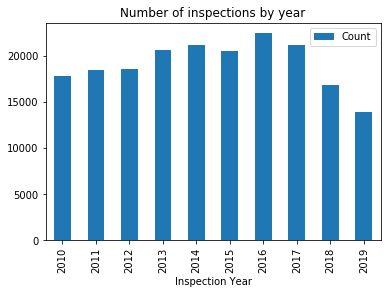

In [65]:
nb_inspections_by_year = df[['Inspection Date', 'Inspection ID']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'Inspection ID' : 'Count'})
nb_inspections_by_year.plot.bar()
plt.title("Number of inspections by year")

Text(0.5, 1.0, 'Number of inspections by month')

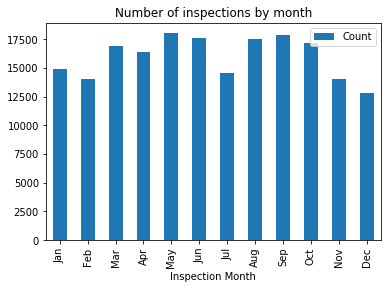

In [66]:
nb_inspections_by_month = df[['Inspection Date', 'Inspection ID']].copy()
nb_inspections_by_month['Inspection Date'] = nb_inspections_by_month['Inspection Date'].apply(lambda x: x.month)
nb_inspections_by_month.rename(columns={'Inspection Date' : 'Inspection Month'}, inplace=True)
nb_inspections_by_month = nb_inspections_by_month.groupby('Inspection Month').count().rename(columns={'Inspection ID' : 'Count'})
nb_inspections_by_month.plot.bar()
plt.gca().set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Number of inspections by month")

### How many inspections are re-inspections?

In [67]:
count_reinspections = df[['Inspection ID', 'Re-inspection']].groupby('Re-inspection').count().rename(columns={'Inspection ID' : 'Count'})
count_reinspections['Percent'] = count_reinspections['Count'] / len(df) * 100
count_reinspections

Count    Percent
Re-inspection                   
False          155124  80.866614
True            36703  19.133386

From here we will not consider re-inspections since they could bias our analysis.

In [68]:
violations_no_reinspection = violations[violations['Re-inspection'] == False]
violations_no_reinspection.head()

Inspection ID            DBA Name       AKA Name  License # Facility Type  \
2        2320412  DANTE'S PIZZA,INC.  DANTE'S PIZZA    2092884    Restaurant   
2        2320412  DANTE'S PIZZA,INC.  DANTE'S PIZZA    2092884    Restaurant   
2        2320412  DANTE'S PIZZA,INC.  DANTE'S PIZZA    2092884    Restaurant   
2        2320412  DANTE'S PIZZA,INC.  DANTE'S PIZZA    2092884    Restaurant   
2        2320412  DANTE'S PIZZA,INC.  DANTE'S PIZZA    2092884    Restaurant   

   Risk               Address    Zip Inspection Date Inspection Type  ...  \
2  High  3028 W ARMITAGE AVE   60647      2019-10-24         Canvass  ...   
2  High  3028 W ARMITAGE AVE   60647      2019-10-24         Canvass  ...   
2  High  3028 W ARMITAGE AVE   60647      2019-10-24         Canvass  ...   
2  High  3028 W ARMITAGE AVE   60647      2019-10-24         Canvass  ...   
2  High  3028 W ARMITAGE AVE   60647      2019-10-24         Canvass  ...   

    Latitude  Longitude  Re-inspection     Community  Neighborhood Ward  \
2  41.917539 -87.703728          False  LOGAN SQUARE  LOGAN SQUARE   32   
2  41.917539 -87.703728          False  LOGAN SQUARE  LOGAN SQUARE   32   
2  41.917539 -87.703728          False  LOGAN SQUARE  LOGAN SQUARE   32   
2  41.917539 -87.703728          False  LOGAN SQUARE  LOGAN SQUARE   32   
2  41.917539 -87.703728          False  LOGAN SQUARE  LOGAN SQUARE   32   

  Precinct Violation ID                                            Meaning  \
2       22           38  Flow of air from kitchen not discharged above ...   
2       22           47                                               None   
2       22           53                                               None   
2       22           55                                               None   
2       22           58                                               None   

   Violation Severity  
2                 Low  
2                 Low  
2                 Low  
2                 Low  
2                 Low  

[5 rows x 22 columns]

### Which violations are the most common?

In [69]:
all_violations_ids = violations_no_reinspection['Violation ID'].unique()
all_violations_ids.sort()
all_violations_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 70], dtype=int64)

In [70]:
violations_id_count = violations_no_reinspection[['Inspection ID', 'Violation ID']].groupby('Violation ID').count().rename(columns={'Inspection ID' : 'Count'})
violations_id_count['Meaning'] = violations_id_count.index.to_series().apply(lambda x: violation_id_meaning.at[x, 'Meaning'] if x in violation_id_meaning.index else None)
violations_id_count.sort_values('Count', ascending=False).head(10)

Count                                            Meaning
Violation ID                                                          
34            60584                               Floors are not clean
33            54374  Equipment or ustensils not cleaned after each use
35            53686  Walls or ceilings are not clean or not in good...
38            48119  Flow of air from kitchen not discharged above ...
32            45433  Equipment or utensils not easily cleanable or ...
41            29296  Offensive odors / Cleaning equipment not store...
36            23304  Not enough light where food is prepared / No p...
3             16735                  Food storage temperature problems
18            15637                   No measures against infestations
30            14060  Food not stored in original or properly labele...

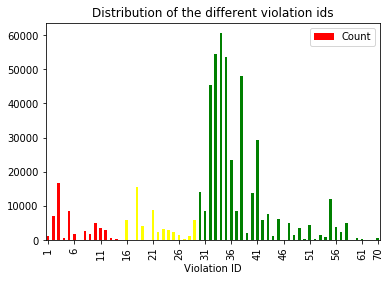

In [71]:
colors = [['red']*14 + ['yellow']*15 + ['green']*(len(violations_id_count) - 14 - 15)]
violations_id_count.plot.bar(color=colors)
plt.title("Distribution of the different violation ids")
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
xticks[-1].set_visible(True)

### Are the violations mostly severe?

In [72]:
violations_severity_count = violations_no_reinspection[['Inspection ID', 'Violation Severity']].groupby('Violation Severity').count().rename(columns={'Inspection ID' : 'Count'})
violations_severity_count['Percent'] = violations_severity_count['Count'].apply(lambda x: "%.3f" % (x/len(violations_no_reinspection)*100))
violations_severity_count

Count Percent
Violation Severity                
High                 52327   9.851
Low                 424494  79.919
Medium               54337  10.230

Text(0.5, 1.0, 'Distribution of the severity levels for the violations')

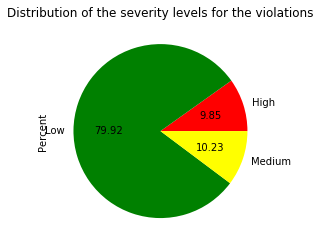

In [73]:
violations_severity_count['Percent'].astype(float).plot.pie(autopct='%.2f', colors=['red', 'green', 'yellow'], fontsize=10)
plt.title("Distribution of the severity levels for the violations")

In [74]:
df_violation_ids = df_split.copy()
df_violation_ids['Violation IDs'] = df_violation_ids['Violations'].apply(lambda violations: [get_violation_id(x) for x in violations])
df_violation_ids['Nb Violations'] = df_violation_ids['Violation IDs'].apply(lambda x: 0 if 'None' in x else len(x))
df_violation_ids[['Violations', 'Violation IDs', 'Nb Violations']].head()

Violations  \
0                                             [None]   
1  [3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...   
2  [38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...   
3  [3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...   
4  [14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TA...   

                              Violation IDs  Nb Violations  
0                                    [None]              0  
1            [3, 5, 25, 50, 53, 53, 56, 58]              8  
2                  [38, 47, 53, 55, 58, 60]              6  
3                       [3, 48, 51, 55, 58]              5  
4  [14, 25, 41, 47, 48, 55, 56, 57, 58, 60]             10

In [75]:
df_violation_ids['Nb Violations of high severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_high_severity(int(x))]))
df_violation_ids['Nb Violations of medium severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_medium_severity(int(x))]))
df_violation_ids['Nb Violations of low severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_low_severity(int(x))]))
df_violation_ids[['Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].head()

Nb Violations  Nb Violations of high severity  \
0              0                               0   
1              8                               2   
2              6                               0   
3              5                               1   
4             10                               1   

   Nb Violations of medium severity  Nb Violations of low severity  
0                                 0                              0  
1                                 1                              5  
2                                 0                              6  
3                                 0                              4  
4                                 1                              8

Text(0.5, 1.0, 'Distribution of the number of violations by inspection')

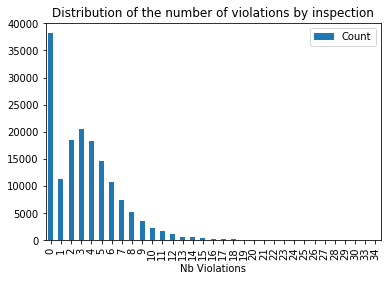

In [76]:
df_violation_ids_no_reinspection = df_violation_ids[df_violation_ids['Re-inspection'] == False]
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations']].groupby('Nb Violations').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar()
plt.title("Distribution of the number of violations by inspection")

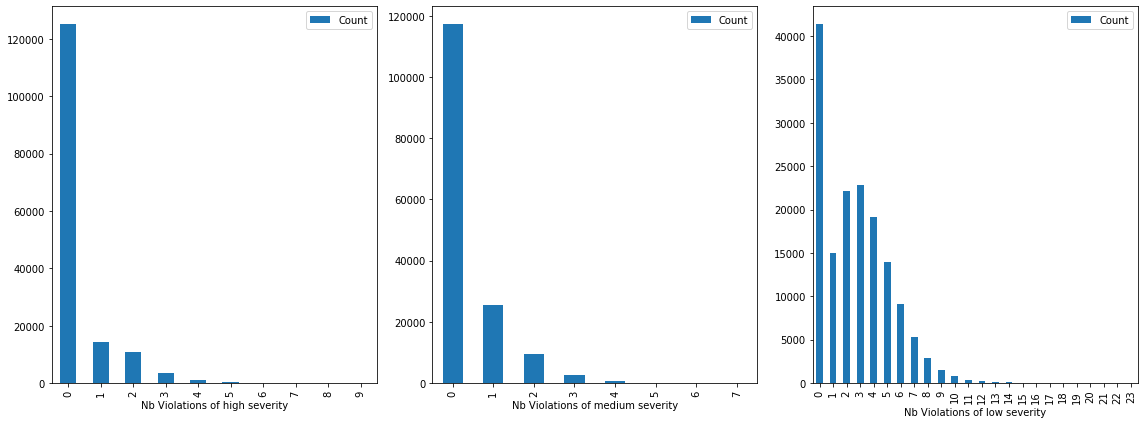

In [77]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations of high severity']].groupby('Nb Violations of high severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax1)
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations of medium severity']].groupby('Nb Violations of medium severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax2)
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations of low severity']].groupby('Nb Violations of low severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax3)
plt.tight_layout()

## Save the dataset with even more information

In [78]:
df_violation_ids.to_parquet('resources/extended_dataset.parquet')

### How does the number of violations vary over time?

In [79]:
nb_violations_by_date = df_violation_ids_no_reinspection[['Inspection Date', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Date').sum()
nb_violations_by_date.head()

Nb Violations  Nb Violations of high severity  \
Inspection Date                                                  
2010-01-04                  16                               0   
2010-01-05                 221                               4   
2010-01-06                 264                              13   
2010-01-07                 170                               5   
2010-01-08                 116                               4   

                 Nb Violations of medium severity  \
Inspection Date                                     
2010-01-04                                      3   
2010-01-05                                     18   
2010-01-06                                     37   
2010-01-07                                      9   
2010-01-08                                      8   

                 Nb Violations of low severity  
Inspection Date                                 
2010-01-04                                  13  
2010-01-05                                 199  
2010-01-06                                 214  
2010-01-07                                 156  
2010-01-08                                 104

In [80]:
nb_violations_by_date.sort_values('Nb Violations', ascending=False).head()

Nb Violations  Nb Violations of high severity  \
Inspection Date                                                  
2019-04-23                 493                             117   
2019-02-21                 482                             134   
2019-05-20                 476                             125   
2019-02-25                 475                             130   
2019-06-17                 463                             113   

                 Nb Violations of medium severity  \
Inspection Date                                     
2019-04-23                                     61   
2019-02-21                                     66   
2019-05-20                                     53   
2019-02-25                                     50   
2019-06-17                                     47   

                 Nb Violations of low severity  
Inspection Date                                 
2019-04-23                                 315  
2019-02-21                                 282  
2019-05-20                                 298  
2019-02-25                                 295  
2019-06-17                                 303

Text(0.5, 1.0, 'Variation of the number of violations over inspections')

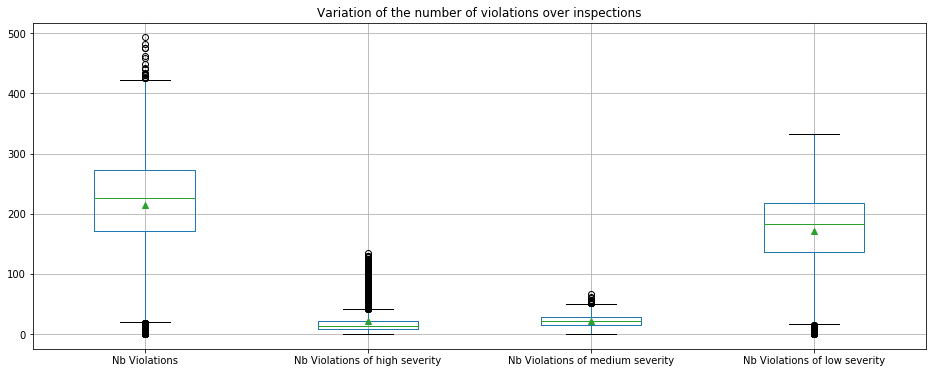

In [81]:
nb_violations_by_date.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the number of violations over inspections")

In [82]:
nb_violations_by_year = nb_violations_by_date.copy().reset_index()
nb_violations_by_year['Inspection Date'] = nb_violations_by_year['Inspection Date'].apply(lambda x: x.year)
nb_violations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_violations_by_year = nb_violations_by_year.groupby('Inspection Year').mean()
nb_violations_by_year.head()

Nb Violations  Nb Violations of high severity  \
Inspection Year                                                  
2010                181.675472                       11.456604   
2011                208.434783                       11.794466   
2012                190.047059                       11.509804   
2013                205.273092                       11.465863   
2014                226.888889                       14.357143   

                 Nb Violations of medium severity  \
Inspection Year                                     
2010                                    16.135849   
2011                                    18.992095   
2012                                    18.854902   
2013                                    20.068273   
2014                                    21.202381   

                 Nb Violations of low severity  
Inspection Year                                 
2010                                154.083019  
2011                                177.648221  
2012                                159.682353  
2013                                173.738956  
2014                                191.329365

Text(0.5, 1.0, 'Mean number of violations by inspection for each year')

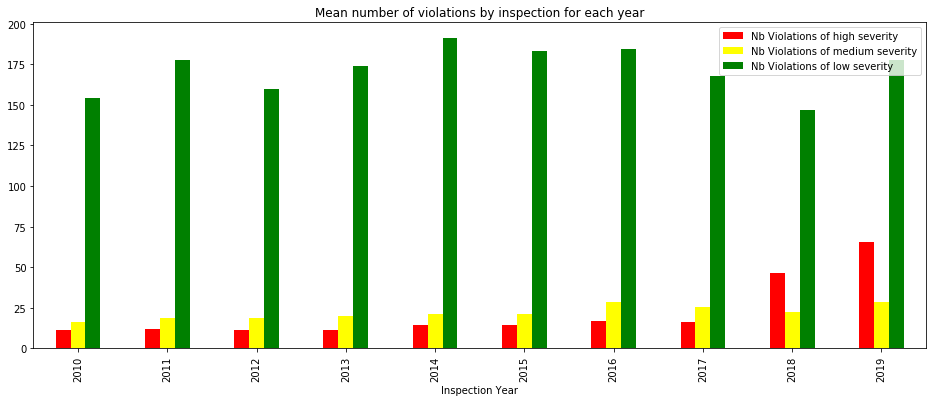

In [83]:
nb_violations_by_year[['Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].plot.bar(color=['red', 'yellow', 'green'], figsize=(16,6))
plt.title("Mean number of violations by inspection for each year")

### Which facility types are more violation-prone?

In [84]:
mean_nb_violations_by_facility = df_violation_ids_no_reinspection[['Facility Type', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Facility Type').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_facility.head()

Nb Violations  Nb Violations of high severity  \
Facility Type                                                          
Long term care center       4.237579                        0.476965   
Bakery                      3.943231                        0.345415   
Restaurant                  3.675696                        0.370839   
Grocery store               3.630098                        0.328505   
Gas station                 3.603774                        0.383648   

                       Nb Violations of medium severity  \
Facility Type                                             
Long term care center                          0.392051   
Bakery                                         0.362445   
Restaurant                                     0.374384   
Grocery store                                  0.395429   
Gas station                                    0.421384   

                       Nb Violations of low severity  
Facility Type                                         
Long term care center                       3.368564  
Bakery                                      3.235371  
Restaurant                                  2.930473  
Grocery store                               2.906163  
Gas station                                 2.798742

In [85]:
mean_nb_violations_by_facility.sort_values('Nb Violations').head()

Nb Violations  Nb Violations of high severity  \
Facility Type                                                          
Unknown                     0.080580                        0.012151   
Shared kitchen              0.825342                        0.071918   
Mobile food dispenser       1.282110                        0.389908   
Rooftop                     1.795455                        0.303030   
Coffee shop                 1.892857                        0.250000   

                       Nb Violations of medium severity  \
Facility Type                                             
Unknown                                        0.008740   
Shared kitchen                                 0.075342   
Mobile food dispenser                          0.215596   
Rooftop                                        0.136364   
Coffee shop                                    0.185714   

                       Nb Violations of low severity  
Facility Type                                         
Unknown                                     0.059689  
Shared kitchen                              0.678082  
Mobile food dispenser                       0.676606  
Rooftop                                     1.356061  
Coffee shop                                 1.457143

Text(0.5, 1.0, 'Variation of the mean number of violations by facility type')

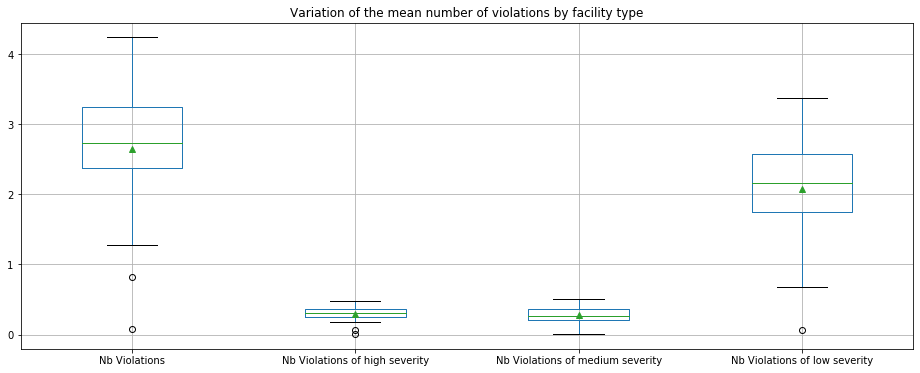

In [86]:
mean_nb_violations_by_facility.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the mean number of violations by facility type")

### Which communities have more violations? ##

In [87]:
mean_nb_violations_by_community = df_violation_ids_no_reinspection[['Community', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Community').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_community.head()

Nb Violations  Nb Violations of high severity  \
Community                                                        
WEST RIDGE            4.362032                        0.416845   
SOUTH LAWNDALE        4.234606                        0.414409   
NORTH PARK            4.139660                        0.371914   
WASHINGTON PARK       4.118393                        0.397463   
HYDE PARK             4.107520                        0.446240   

                 Nb Violations of medium severity  \
Community                                           
WEST RIDGE                               0.429679   
SOUTH LAWNDALE                           0.438732   
NORTH PARK                               0.356481   
WASHINGTON PARK                          0.562368   
HYDE PARK                                0.418272   

                 Nb Violations of low severity  
Community                                       
WEST RIDGE                            3.515508  
SOUTH LAWNDALE                        3.381466  
NORTH PARK                            3.411265  
WASHINGTON PARK                       3.158562  
HYDE PARK                             3.243008

In [88]:
mean_nb_violations_by_community.sort_values('Nb Violations').head()

Nb Violations  Nb Violations of high severity  \
Community                                                        
NEAR SOUTH SIDE       2.721331                        0.332739   
LOOP                  2.788435                        0.292631   
GARFIELD RIDGE        2.795533                        0.219931   
RIVERDALE             2.798611                        0.159722   
EAST SIDE             2.810580                        0.257679   

                 Nb Violations of medium severity  \
Community                                           
NEAR SOUTH SIDE                          0.274510   
LOOP                                     0.244305   
GARFIELD RIDGE                           0.235395   
RIVERDALE                                0.361111   
EAST SIDE                                0.257679   

                 Nb Violations of low severity  
Community                                       
NEAR SOUTH SIDE                       2.114082  
LOOP                                  2.251499  
GARFIELD RIDGE                        2.340206  
RIVERDALE                             2.277778  
EAST SIDE                             2.295222

Text(0.5, 1.0, 'Variation of the mean number of violations by facility type')

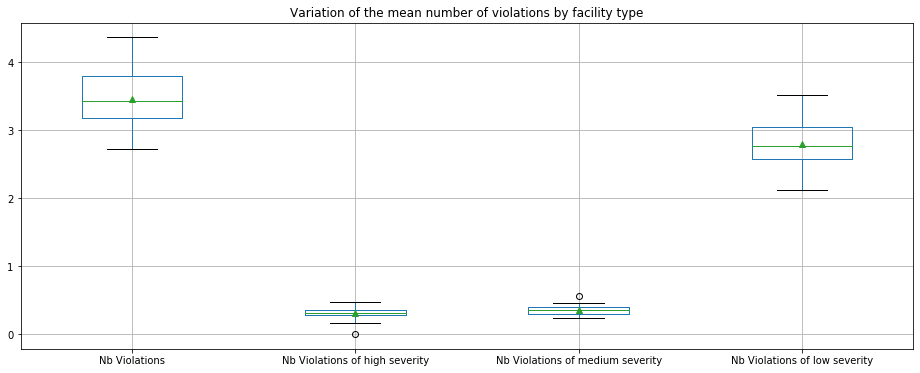

In [89]:
mean_nb_violations_by_community.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the mean number of violations by facility type")

In [90]:
m_violations = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
nds = pd.DataFrame()
nds['Community'] = mean_nb_violations_by_community.index.astype('str')
nds['Nb Violations'] = mean_nb_violations_by_community['Nb Violations'].values
fe1 = fo.Choropleth(
    geo_data='resources/geojsons/chicago-community.geojson',
    name='Violations by communities',
    data=nds,
    columns=['Community', 'Nb Violations'],
    key_on='properties.community',
    fill_color='Reds',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name=' Mean of number of violations by community (in %)'
)
fe1.add_to(m_violations)
m_violations.save(outfile='results/community-violations-mean.html')
m_violations

### How much does failing an inspection is linked to the number of violations?

In [91]:
mean_nb_violations_by_result = df_violation_ids_no_reinspection[['Results', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Results').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_result.head()

Nb Violations  Nb Violations of high severity  \
Results                                                             
Fail                     5.876186                        0.712516   
Pass w/ Conditions       5.407404                        1.241328   
Pass                     2.809281                        0.003976   
No Entry                 0.119362                        0.003087   
Not Ready                0.060369                        0.010061   

                    Nb Violations of medium severity  \
Results                                                
Fail                                        1.196146   
Pass w/ Conditions                          0.594660   
Pass                                        0.002888   
No Entry                                    0.001715   
Not Ready                                   0.006708   

                    Nb Violations of low severity  
Results                                            
Fail                                     3.967524  
Pass w/ Conditions                       3.571416  
Pass                                     2.802418  
No Entry                                 0.114560  
Not Ready                                0.043600

In [92]:
mean_nb_violations_by_result_and_reinspection = df_violation_ids[['Results', 'Re-inspection', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby(['Results', 'Re-inspection']).mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_result_and_reinspection

Nb Violations  \
Results              Re-inspection                  
Fail                 False               5.876186   
Not Ready            True                5.428571   
Pass w/ Conditions   False               5.407404   
Fail                 True                5.306931   
Pass w/ Conditions   True                5.195188   
No Entry             True                4.383041   
Pass                 False               2.809281   
                     True                1.719682   
Out of Business      True                0.604167   
No Entry             False               0.119362   
Not Ready            False               0.060369   
Out of Business      False               0.002355   
Business Not Located False               0.000000   

                                    Nb Violations of high severity  \
Results              Re-inspection                                   
Fail                 False                                0.712516   
Not Ready            True                                 1.371429   
Pass w/ Conditions   False                                1.241328   
Fail                 True                                 0.805174   
Pass w/ Conditions   True                                 1.183780   
No Entry             True                                 0.330409   
Pass                 False                                0.003976   
                     True                                 0.004610   
Out of Business      True                                 0.010417   
No Entry             False                                0.003087   
Not Ready            False                                0.010061   
Out of Business      False                                0.000060   
Business Not Located False                                0.000000   

                                    Nb Violations of medium severity  \
Results              Re-inspection                                     
Fail                 False                                  1.196146   
Not Ready            True                                   0.657143   
Pass w/ Conditions   False                                  0.594660   
Fail                 True                                   0.747684   
Pass w/ Conditions   True                                   0.586062   
No Entry             True                                   1.023392   
Pass                 False                                  0.002888   
                     True                                   0.005470   
Out of Business      True                                   0.125000   
No Entry             False                                  0.001715   
Not Ready            False                                  0.006708   
Out of Business      False                                  0.000121   
Business Not Located False                                  0.000000   

                                    Nb Violations of low severity  
Results              Re-inspection                                 
Fail                 False                               3.967524  
Not Ready            True                                3.400000  
Pass w/ Conditions   False                               3.571416  
Fail                 True                                3.754072  
Pass w/ Conditions   True                                3.425347  
No Entry             True                                3.029240  
Pass                 False                               2.802418  
                     True                                1.709602  
Out of Business      True                                0.468750  
No Entry             False                               0.114560  
Not Ready            False                               0.043600  
Out of Business      False                               0.002174  
Business Not Located False                               0.000000

### Which inspection types lead to highest number of violations found? ##

In [93]:
mean_nb_violations_by_inspection_type = df_violation_ids_no_reinspection[['Inspection Type', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Type').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_inspection_type

Nb Violations  Nb Violations of high severity  \
Inspection Type                                                         
Suspect food poisoning       5.001208                        0.711353   
Complaint                    4.429702                        0.458496   
Canvass                      3.412136                        0.306883   
Others                       3.129543                        0.164026   
License                      2.556591                        0.346744   
Consultation                 2.434655                        0.099853   
Task-force                   2.352877                        0.301846   
Cancelled                    0.125749                        0.000000   
Unknown                      0.000000                        0.000000   

                        Nb Violations of medium severity  \
Inspection Type                                            
Suspect food poisoning                          0.507246   
Complaint                                       0.488334   
Canvass                                         0.327308   
Others                                          0.171482   
License                                         0.314810   
Consultation                                    0.221733   
Task-force                                      0.398480   
Cancelled                                       0.017964   
Unknown                                         0.000000   

                        Nb Violations of low severity  
Inspection Type                                        
Suspect food poisoning                       3.782609  
Complaint                                    3.482872  
Canvass                                      2.777945  
Others                                       2.794035  
License                                      1.895037  
Consultation                                 2.113069  
Task-force                                   1.652552  
Cancelled                                    0.107784  
Unknown                                      0.000000

### Do the facilities marked as Risky have more/less violations compared to lower risk facilities? ##

In [94]:
mean_nb_violations_by_risk = df_violation_ids_no_reinspection[['Risk', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Risk').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_risk

Nb Violations  Nb Violations of high severity  \
Risk                                                    
High         3.728862                        0.373696   
Medium       3.046947                        0.281287   
Low          1.796921                        0.167207   
All          0.000000                        0.000000   

        Nb Violations of medium severity  Nb Violations of low severity  
Risk                                                                     
High                            0.365723                       2.989444  
Medium                          0.348510                       2.417150  
Low                             0.230333                       1.399381  
All                             0.000000                       0.000000

### Can we see infestations rising during the Chicago's rodent invasion?

Text(0.5, 1.0, 'Mean number of infestations by inspection for each year')

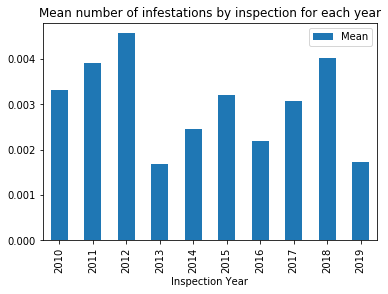

In [95]:
def intersection(list1, list2):
    return list(set(list1) & set(list2))

def analyse_frequency_violations(ids, all_ids_must_appear=False):
    result = df_violation_ids_no_reinspection[['Inspection Date', 'Violation IDs']].copy()
    result['Inspection Date'] = result['Inspection Date'].apply(lambda x: x.year)
    result.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
    if all_ids_must_appear:
        result['Qualify'] = result['Violation IDs'].apply(lambda x: 1 if len(intersection(ids, x)) == len(ids) else 0)
    else:
        result['Qualify'] = result['Violation IDs'].apply(lambda x: 1 if len(intersection(ids, x)) > 0 else 0)
    result = result.groupby('Inspection Year').mean().rename(columns={'Qualify' : 'Mean'})
    return result

nb_infestations_by_year = analyse_frequency_violations(['13'])
nb_infestations_by_year.plot.bar()
plt.title("Mean number of infestations by inspection for each year")

Sadly, it seems that we cannot see the rodent invastion from the number of 'infestations' violations ! https://southsideweekly.com/i-smell-a-rat/

### How do some interesting violations vary over time?

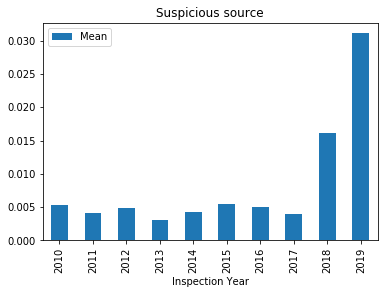

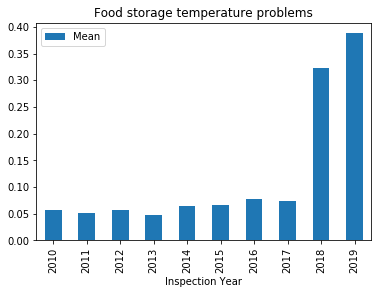

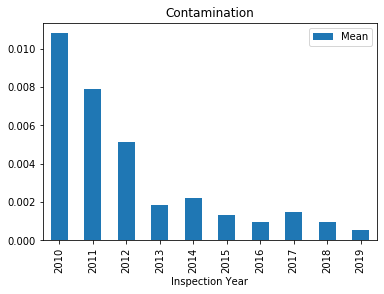

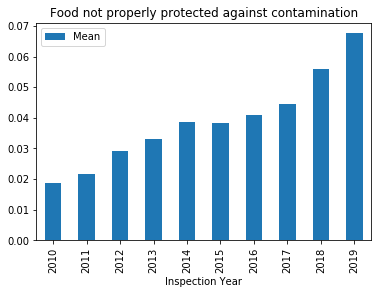

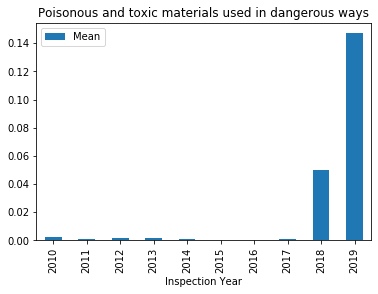

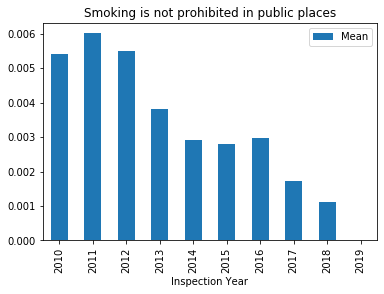

In [96]:
interesting_ids = [1, 3, 4, 16, 25, 70]
for violation_id in interesting_ids:
    analyse_by_year = analyse_frequency_violations([str(violation_id)])
    analyse_by_year.plot.bar()
    plt.title(violation_id_meaning.loc[violation_id][0])

The violation's types vary over years. For example, the food storage temperature problems and poisonous/toxic problems are more common nowadays than before (maybe because of the [global warming and pollution]() ). I contrast, Smoking is prohibited in public places so this violations decrease slowly over the last 10 years.